# Array-based recast of DECSKS p1: <font color = "red">DECSKS-v1.2</font> $\Rightarrow$ <font color = "green">DECSKS-v2.0</font>

#### For easy identification: changes to the code are titled in <font color = "green">green</font> for DECSKS-v2.0 and in <font color = "red">red</font> for the old DECSKS-v1.2 code that is being analyzed here to discern the appropriate changes.

In [2]:
%reload_ext autoreload
%autoreload 2 
from IPython.display import Image

The serial processing time required for simulation on DECSKS v1.2 is already approaching significant runtime.

We show a plot of some simulation times for test cases so far for motivation (cases from the notebook <a href = "../DECSKS-07%20-%201D1V-Landau_damping/DECSKS-07%20--%201D1V%20Linear%20Landau%20damping.ipynb">DECSKS-07 1D1V Linear Landau damping</a>)

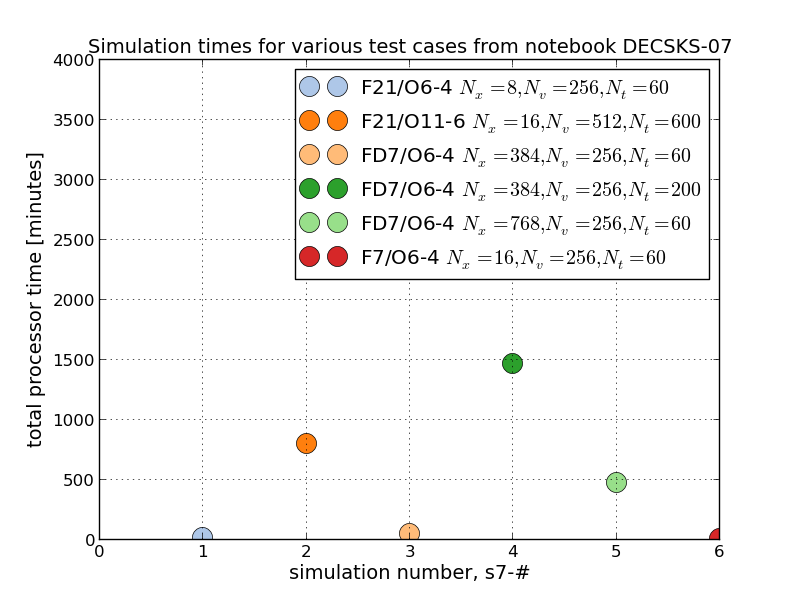

In [10]:
Image(filename = 'fig/simtimes.png')

At longest, we have a runtime of 1466.77 minutes = 24.4462 hours for FD7, O6-4 splitting, on a grid $N_x \times N_v = 384 \times 256$ for $N_t = 200$ timesteps. This is not agreeable to scaling to higher dimensions. <b>The aim of this notebook is to eliminate the most direct cause of bottlenecks in the code insofar, that is to recast looping implementations with equivalent numpy array computations. This will be versioned as DECSKS-v2.0</b>. The most laborious stepthrough for this looping is in the splitting algorithm and the subsequent implementation of convected scheme through the DECSKS.lib.convect.scheme method where we reduce the problem in phase space with $N_x\times N_v$ to $N_v$ nodes to an equivalent set of 1D advection problems. That is, for each $v$ we cycle through $N_v$ 1D advection problems in $x$ ($\partial_t f + v\partial_x f = 0$). In the next step, for each $x$ we cycle through $N_x$ 1D advection problems in $v$ ($\partial_t f + a\partial_v f = 0$). Below, we show the full method DECSKS.lib.split.scheme to concretize how this splitting is encoded.

#### <font color = "red">DECSKS-v1.2: lib.split.scheme</font>

In [14]:
#import DECSKS ; this line has been commented out since IPython does not support package hierarchies
import time

def scheme(
        f,
        t,x,v,
        n,
        sim_params
        ):
    """Steps through 1D-1V Vlasov with chosen splitting scheme.

    inputs:
    f -- (ndarray, dim=3) f(t,x,v) with f(0,x,v) = f_0 initialized
    x -- (instance) x, space
    v -- (instance) v, velocity
    t -- (instance) time
    n -- (int) current time step index, t^n
    sim_params -- (dict) simulation parameters

    outputs:
    f -- (ndarray, dim=3) f(n+1, x,v)
    """

    # retrieve sub-dictionary containing splitting coefficients and composition order
    splitting = sim_params['splitting']
    coeff = splitting['order']['coeffs']
    stage = splitting['order']['stages']
    tic = time.time()
    for s in range(len(stage)):
        split_coeff = splitting[coeff[s]][int(stage[s])]
        if s == 0: # on first pass, the previous time step (n - 1) needs to be
            if coeff[s] == 'a': # convect x
                for j in v.prepoints:
                    x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues[j], split_coeff*t.width)
                    f[n,:,j] = DECSKS.lib.convect.scheme(
                        f[n-1,:,j],
                        x,n,
                        sim_params)

            elif coeff[s] == 'b': # convect v
                E = DECSKS.lib.fieldsolvers.Gauss(sim_params['ni'], f, x, v, n-1) # calculate accelerations at time zero (n-1)
                a = -E
                for i in x.prepoints:
                    v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a[i], split_coeff*t.width)
                    f[n,i,:] = DECSKS.lib.convect.scheme(
                        f[n-1,i,:],
                        v,n,
                        sim_params)

        else: # each subsequent steps overwrites the previous step, all at time n until all split steps complete
            if coeff[s] == 'a': # convect x
                for j in v.prepoints:
                    x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues[j], split_coeff*t.width)
                    f[n,:,j] = DECSKS.lib.convect.scheme(
                        f[n,:,j],
                        x,n,
                        sim_params)

            elif coeff[s] == 'b': # convect v
                E = DECSKS.lib.fieldsolvers.Gauss(sim_params['ni'], f, x, v, n)
                a = -E
                for i in x.prepoints:
                    v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a[i], split_coeff*t.width)
                    f[n,i,:] = DECSKS.lib.convect.scheme(
                        f[n,i,:],
                        v,n,
                        sim_params)

    toc = time.time()
    print "time step %d of %d completed in %g seconds" % (n,t.N, toc - tic)

    return f


The method first extracts a subdictionary sim_params['splitting'] and stores it locally as $\text{splitting}$:

In [ ]:
    # retrieve sub-dictionary containing splitting coefficients and composition order
    splitting = sim_params['splitting']

    
(the key 'splitting' corresponds to a scheme-specific dictionary value that contains all the required information to access each splitting coefficient and instructions on which order to apply it in with regard to the compositional application of split operators). The user specifies the splitting method in the input file etc/params.dat)
    
For the sake of example, suppose we indicate in the input file (etc/params.dat) to use 'O6-4'. We will use this example to explain how each splitting coefficient is accessed at each time substep in the split scheme.

sim_params['splitting'] is a dictionary that has already been assembled in a DECSKS.lib.read method prior to the start of the simulation. This dictionary is itself houses a dictionary container 'order' whose keys 'coeffs' and 'stages' correspond to values which are themselves lists 

In [ ]:
    coeff = splitting['order']['coeffs']
    stage = splitting['order']['stages']

'coeffs' is a list of coefficients that communicates the order of composition which are marked as either 'a' coefficients or 'b' coefficients in every splitting scheme. 

For the example of O6-4,

    coeff = ['b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']

'stages' is a list of numbers enumerating the current substage of the subcycling in time. For the case of O6-4,

    stage = ['1', '1', '2', '2', '3', '3', '4', '3', '3', '2', '2', '1', '1']
    
The tandem use of the lists coeff and stage permit the code to access each splitting coefficients without additional if/else layering by allowing access to the compositional ordering of labelled coefficients for O6-4 as:

    b1, a1, b2, a2, b3, a3, b4, a3, b3, a2, b2, a1, b1
    
which explicitly are accessed as

    splitting['b']['1'], splitting['a']['1'], splitting['b']['2'], splitting['a']['2'], ... etc.

and stored for immediate use in the variable $\text{split_coeff}$ as

    split_coeff = splitting[coeff[s]][int(stage[s])]
    
as shown in the above code while looping through $\text{s}$. Thus, the fractional substep for a full step $\Delta t \equiv \text{t.width}$  is computed as $\text{split_coeff * t.width}$.
    
The values of split_coeff at each stage for O6-4 are (stored in etc/params_splitting_coeffs.dat and read into sim_params['splitting'] automatically before the simulation starts) are:

    a1 = 0.245298957184271
    a2 = 0.604872665711080
    a3 = 1/2. - (a1 + a2)
    a4 = 0.

    b1 = 0.0829844064174052
    b2 = 0.396309801498368
    b3 = -0.0390563049223486
    b4 = 1.0 - 2*(b1 + b2 + b3)
    
which can be found in literature (e.g. Blanes, et al.). <font color = "red">(TODO) the subdictionary 'order' is deprecated (at one point it had a use, but its use has been since removed). Should eliminate this extraneous key entry, to access each list as sim_params['splitting']['coeffs'] and sim_params['splitting']['stages'].</font> The bottom line with this construction (accessing split schemes as a dictionary of dictionary of dictionaries) is that it allows us to evade needless conditional checks for this while giving us the versatility to store and use any scheme in general where the only change on the user end is to change one keyword in an input file (specifying the split scheme). We reduce a large nest of conditional checks to just one check: "is the coefficient 'a' or 'b'?". The expense in this one check is not a concern.

Note: There is nothing special about 'a' or 'b'. They simply represent the coefficient in the compositional application of time splitting (Lie) operators $e^{(A + B)\Delta t} = e^{a_1\Delta t A} \circ e^{b_1\Delta t B} \circ \cdots \circ e^{b_S\Delta t B} e^{a_S\Delta t A}$ (for example, it can also be the case that we interleave operators oppositely with B being the first and last application). It is a user choice to designate one or the other as $x$ or $v$ convection. Here, we decide to choose 'a' as $x$ and 'b' as $v$ convection. Here, convecting in $v$ requires computing a self-consistent acceleration term that in the 1D1V Vlasov-Poisson system is attributed only to the electrostatic potential ($\phi = \phi (t,\vec{x})$).

The bottleneck we <b>do</b> wish to apprehend is inside the splitting coefficient conditional check:

#### <font color = "red">DECSKS-v1.2: lib.convect.scheme excerpt</font>

In [ ]:
            if coeff[s] == 'a': # convect x
                for j in v.prepoints:
                    x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues[j], split_coeff*t.width)
                    f[n,:,j] = DECSKS.lib.convect.scheme(
                        f[n,:,j],
                        x,n,
                        sim_params)

            elif coeff[s] == 'b': # convect v
                E = DECSKS.lib.fieldsolvers.Gauss(sim_params['ni'], f, x, v, n)
                a = -E
                for i in x.prepoints:
                    v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a[i], split_coeff*t.width)
                    f[n,i,:] = DECSKS.lib.convect.scheme(
                        f[n,i,:],
                        v,n,
                        sim_params)

The $\text{for}$ loops here require the largest amount of computation time. The form of both blocks of code are the same, consider the top block of code,

In [ ]:
                for j in v.prepoints:
                    x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues[j], split_coeff*t.width)
                    f[n,:,j] = DECSKS.lib.convect.scheme(
                        f[n,:,j],
                        x,n,
                        sim_params)

                        
which states we pass 1D arrays one at a time (at each $v = v_j$) through the DECSKS.lib.convect.scheme method (i.e. we pass each $\underline{f}(t^n, \underline{x}, v_j)$ for all $j$, these are themselves 1D advection problems). The next block of code does the opposite: we pass each $\underline{f}(t^n, x_i, \underline{v})$ for all $i$. This stepthrough, while straightforward and most natural, is laborious and expensive! <b> We would like to pass $\underline{\underline{f}}(t^n,\underline{x}, \underline{v})$ as one object, and to adapt DECSKS.lib.convect.scheme to solve all 1D arrays at once using multidimensional numpy array operations rather than operations on 1D arrays separately.</b> Since this is a top-level change, everything underneath it will need to be modified accordingly. We step through the code below in order to carefully learn what needs to be changed and what can remain the same. For 2D objects (1D1V) and 1D objects (1D0V) objects to be passed, the obvious changes to the split scheme above is:

#### <font color = "green">DECSKS-v2.0: lib.split.scheme</font>

In [15]:
import DECSKS
import numpy as np
import time

def scheme(
        f,
        t,x,vx,
        n,
        sim_params
        ):
    """Steps through 1D-1V Vlasov with chosen splitting scheme.

    inputs:
    f -- (ndarray, dim=3) f(t,x,v) with f(0,x,v) = f_0 initialized
    x -- (instance) x, space
    v -- (instance) v, velocity
    t -- (instance) time
    n -- (int) current time step index, t^n
    sim_params -- (dict) simulation parameters

    outputs:
    f -- (ndarray, dim=3) f(n+1,x,v)
    """
    # retrieve sub-dictionary containing splitting coefficients and composition order
    splitting = sim_params['splitting']
    coeff = splitting['order']['coeffs']
    stage = splitting['order']['stages']
    tic = time.time()
    for s in range(len(stage)):
        split_coeff = splitting[coeff[s]][int(stage[s])]
        if s == 0: # on first pass, the previous time step (n - 1) needs to be
            if coeff[s] == 'a': # convect x
                x.generate_Lagrangian_mesh(vx.prepointvaluemesh, split_coeff*t.width)
                f[n,:,:] = DECSKS.lib.convect.scheme(
                        f[n-1,:,:],
                        x,n,
                        sim_params)

            elif coeff[s] == 'b': # convect v
                E = DECSKS.lib.fieldsolvers.Gauss(sim_params['ni'], f, x, vx, n-1) # calculate accelerations at time zero (n-1)
                a = -E

                vx.generate_Lagrangian_mesh(a, split_coeff*t.width)
                f[n,:,:] = DECSKS.lib.convect.scheme(
                    f[n-1,:,:],
                    vx,n,
                    sim_params)

        else: # each subsequent steps overwrites the previous step, all at time n until all split steps complete
            if coeff[s] == 'a': # convect x
                x.generate_Lagrangian_mesh(vx.prepointvaluemesh, split_coeff*t.width)
                f[n,:,:] = DECSKS.lib.convect.scheme(
                        f[n,:,:],
                        x,n,
                        sim_params)

            elif coeff[s] == 'b': # convect v
                E = DECSKS.lib.fieldsolvers.Gauss(sim_params['ni'], f, x, vx, n)
                a = -E

                vx.generate_Lagrangian_mesh(a, split_coeff*t.width)
                f[n,:,:] = DECSKS.lib.convect.scheme(
                        f[n,:,:],
                        vx,n,
                        sim_params)

    toc = time.time()
    print "time step %d of %d completed in %g seconds" % (n,t.N, toc - tic)

    return f

Note, a decision has been made to assemble all arrays with dimensions [x.N, v.N] (and not the other way around [v.N, x.N]). Before it goes too long without mention, one line has been added to lib.fieldsolvers to make the electric field vector be a 2D array:

#### <font color = "green">DECKS-v2.0: lib.fieldsolvers.Gauss</font>

In [ ]:
     E = np.outer(E, np.ones([1, v.N]))

    return E

i.e. we compute at the end for $\underline{E} = \underline{E}(\underline{x})$, the outerproduct to create $\underline{\underline{E}}_{2D} = \underline{E}_{N_x\times 1}(\underline{x}) ⊗ \underline{1}_{1\times N_v}$ so thta each column $j$ is the electric field at over all $x_i$ for a given $v_j$.

### Recasting x.MCs and v.MCs into 2D arrays

Above, the affected change is effectively changing:

    if convecting in x:
        for j in v.prepoints:
            x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues[j], frac*t.width)
            f[n,:,j] = DECSKS.lib.convect.scheme(f[n,:,j], x, sim_params, args*)
    
    elif convecting in v:
        compute acceleration a = a(x)
        for i in x.indices:
            v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a[i], frac*t.width)
            f[n,i,:] = DECSKS.lib.convect.scheme(f[n,i,:], v, sim_params, args*)

to

    if convecting in x:
        x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues, frac*t.width)
        f[n,:,:] = DECSKS.lib.convect.scheme(f[n,:,:], sim_params, args*)
    elif convecting in v
        compute acceleration a = a(x)
        v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a, frac*t.width)
        f[n,:,:] = DECSKS.lib.convect.scheme(f[n,:,:], sim_params, args*)
    
where 2D arrays are now passed. 

(note, the phase space variables x and v and time variable t are instantiations of class objects that carry with them attributes that fully characterize them, number of gridpoints, prepoint values, an array container that houses all postpoint locations for the moving cells (MCs) called x.MCs and v.MCs, domain boundaries, and so on. The attribute names below should be clear enough to follow even for someone not developing the code).

Thus, x.MCs and v.MCs should be recasted from 1D arrays to a collection of 1D arrays (i.e. 2D array) that can calculate and store all the MC postpoints for all prepoints in x and v by passing, say instead of v.prepointvalues[j], we pass v.prepointvalues as a whole). NumPy arrays inherit their efficiency by vectorized precompiled C routines that operate on known-size, static, objects. Hence, we require to change the container x.MCs and v.MCs accordingly to accommodate, say in 1D1V a shape x.MCs.shape = (x.N, v.N), and so on.

The initialization of the self.MCs container happens in lib.domain where the objects are instantiated:

#### <font color = "red">DECSKS v1.2: lib.domain constructor excerpt</font>

In [ ]:
    self.MCs = np.zeros(self.N) # container, to be filled at each timestep

We need to modify this so that the container is a size [x.N,v.N] in the 1D1V case, or [x.N, y.N] in the 2D case, or [x.N] in the case of 1D0V, and so on. Since this constructor happens before the simulation begins, we are free to apply conditional checks as needed as these operations will not be repeated and will not add any significant runtime. The instance needs to be created with minding the phase space variables that actually are evolved, and then to create the container in standard order [x,y,z,vx,vy,vz] whose order needs to be encoded as instructions here or can be avoided if we modify the input file (etc/params.dat) and require strict ordering. We pursue this:

#### <font color = "red">DECSKS v1.2: etc/params.dat excerpt (L45)</font>

    number of phase space dimensions (int) = 2

#### <font color = "green">DECSKS-v2.0: etc/params.dat exerpt (L45 change)</font>

    list all evolved phase space variables in order (x,y,z, vx,vy,vz): x,vx
    
(spaces and extra whitespace as usual does not matter for the input file). <font color = "blue">Note: DECSKS will assume you instantiate only the variables exactly as labelled in L45 of etc/params.dat above.</font>

If you do this inconsistently, for example say it is desirable to make the symbols even more brief by writing

    v = DECSKS.lib.domain.Setup(sim_params, var = 'v', dim = 'x')
    
at some point in the simulation an error will be thrown: "UnboundLocalError: local variable 'v' referenced before assignment" if vx is what is listed in L45 of etc/params.dat

This data is read into lib.read and stored in the dictionary sim_params. We store the above list $\text{phasespace_vars}$. That is, lib.read formerly reads as:

#### <font color = "red">DECSKSv1.2: lib.read excerpt (L59)</font>

In [ ]:
    numdims = int(lines[44][lines[44].find('=')+1:].strip())

#### <font color = "red">DECSKSv1.2: lib.read excerpt (L112-132)</font>

In [ ]:
    sim_params = dict(
        N = N, HOC = HOC,
        WindowedFilter = WindowedFilter,
        Nx = Nx, ax = ax, bx = bx,
        # Ny = Ny, ay = ay, by = by,
        # Nz = Nz, az = az, bz = bz,
        Nvx = Nvx, avx = avx, bvx = bvx,
        # Nvy = Nvy, avy = avy, bvy = bvy,
        # Nvz = Nvz, avz = avz, bvz = bvz,
        Nt = Nt, at = at, bt = bt, T = T,
        numdims = numdims, density = density,
        split_scheme = split_scheme,
        splitting = splitting,
        plot_params = plot_params,
        Bernoulli_numbers = Bernoulli_numbers,
        record_outputs = record_outputs,
        outfiles = outfiles,
        FD_schemes = FD_schemes,
        FD_scheme_dn1 = FD_scheme_dn1
        )

    infile.close()

    return sim_params

We modify this to take in the list phasespace_vars and calculate integer numdims as the length of this list

#### <font color = "green">DECSKS-v2.0 lib.read excerpt (L59 - 66)</font>

In [ ]:
    # the following list contains strings identifying all evolved phase
    # space variables, a subset of ['x', 'y', 'z', 'vx', 'vy', 'vz']
    phasespace_vars = lines[44][lines[44].find(':')+1:].strip().split(',')
    # strip all whitespace in each entry
    for var in range(len(phasespace_vars)):
        phasespace_vars[var] = phasespace_vars[var].strip()

    numdims = len(phasespace_vars)

#### <font color = "green">DECSKS-v2.0 lib.read excerpt (L112-133)</font>

In [ ]:
    sim_params = dict(
        N = N, HOC = HOC,
        WindowedFilter = WindowedFilter,
        Nx = Nx, ax = ax, bx = bx,
        # Ny = Ny, ay = ay, by = by,
        # Nz = Nz, az = az, bz = bz,
        Nvx = Nvx, avx = avx, bvx = bvx,
        # Nvy = Nvy, avy = avy, bvy = bvy,
        # Nvz = Nvz, avz = avz, bvz = bvz,
        Nt = Nt, at = at, bt = bt, T = T,
        phasespace_vars = phasespace_vars, 
        numdims = numdims,
        density = density,
        split_scheme = split_scheme,
        splitting = splitting,
        plot_params = plot_params,
        Bernoulli_numbers = Bernoulli_numbers,
        record_outputs = record_outputs,
        outfiles = outfiles,
        FD_schemes = FD_schemes,
        FD_scheme_dn1 = FD_scheme_dn1
        )

    infile.close()

    return sim_params

The constructor lib.domain for phase space variables can then modify the attributes self.MCs to be of the appropriate size:

#### <font color = "red">DECKS-v1.2: lib.domain excerpt (L36 and L75 [same])</font>

In [ ]:
    self.MCs = np.zeros(self.N) # container, to be filled at each timestep

Note that L36 = velocity instantiations, L75 = configuration variable instantiations. The required changes can be casted as (taking into account both periodic situations (active nodes = total gridpoints - 1), and non-periodic (active nodes = total gridpoints).

#### <font color = "green">DECSKS-v2.0: lib.domain excerpt (L36 change, L75 change)</font>

In [ ]:
            if sim_params['numdims'] == 1:
                self.MCs = np.zeros(self.N) # container, to be filled at each timestep

            elif sim_params['numdims'] == 2:
                N1_str = 'N' + sim_params['phasespace_vars'][0] # Nx, Ny, or Nz
                N2_str = 'N' + sim_params['phasespace_vars'][1] # Nvx, Nvy, or Nvz

                N1, N2 = sim_params[N1_str], sim_params[N2_str]
                if sim_params['BC'].lower() == 'periodic':
                    N1 -= 1
                    N2 -= 1
                self.MCs = np.zeros([N1,N2])

i.e. if phasespace_vars = ['x', 'vx'], and in etc/params.dat we specify Nx = 32, Nvx = 64 then

In [ ]:
    N1_str = 'Nx'
    N2_str = 'Nvx'
    
    N1, N2 = sim_params['Nx'], sim_params['Nvx']

and, we create the numpy array container (e.g. for nonperiodic boundary conditions)

In [ ]:
    self.MCs = np.zeros([N1, N2])

which has a shape self.MCs.shape = (32, 64).

If we were to have periodic BCs, then N1 - 1 = 31, and N2 - 1 = 63 gridpoints need to be evolved whereas the final gridpoint is assigned by periodic enforcement. Thus, we have the same gridsize less one in each direction for these cases as usual.

The size readjustment for the fixed sized numpy arrays self.MCs is then completed. We move onto other required changes.

### Generating pospoints: lib.domain.generate_Lagrangian_mesh method

Recall we compute postpoints of MCs (x.MCs and v.MCs) in the split algorithm as the following pseudo-code:

    if convecting in x:
        x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues, frac*t.width)
        f[n,:,:] = DECSKS.lib.convect.scheme(f[n,:,:], sim_params, args*)
    elif convecting in v
        compute acceleration a = a(x)
        v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a, frac*t.width)
        f[n,:,:] = DECSKS.lib.convect.scheme(f[n,:,:], sim_params, args*)
        
For the 1D1V case, we have just above created multi-dimensional array storage for each attribute so that x.MCs.shape = (x.N, v.N), and v.MCs.shape = (x.N, v.N). Both calls use the same method (generate_Lagrangian_mesh). For the sake of example, consider

        x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues, frac*t.width)
        
The method is already vectorized, but does not store the MCs in the designed 2-dimensional container x.MCs or v.MCs automatically. The method will need to be slightly modified to know about this structure. Currently, method reads as:

#### <font color = "red">DECSKS-v1.2: lib.domain.generate_Lagrangian_mesh</font>

In [ ]:
    def generate_Lagrangian_mesh(self, z, vz, dt):
        """Advects all MCs one time step for a phase space variable z.

        inputs:
        z -- (ndarray, dim=1) phase space variable mesh
        vz -- (ndarray, dim=1) velocity vector whose entries pair with each MC
        dt -- (float) time step taken

        outputs:
        z_MC -- (ndarray, dim=1) array of raw positions of each MC after push
        """

        z_MC = z + vz*dt

        return z_MC

For example, suppose we evolve $N_x = 4$ $x$ gridpoints, $\underline{x} = (x_0, x_1, x_2, x_3)$, and evolve $N_v = 5$, velocity gridpoints $\underline{v} = (v_0, v_1, v_2, v_3, v_4)$.  Recall that $\text{x.MCs} \equiv \underline{\underline{x_{MCs}}} = \underline{\underline{x_{MCs}}}_{N_x\times N_v}$, i.e. entries are thepostpoints of the MCs which can be framed as the following individual mappings:

$$\underline{\underline{x_{MCs}}} = \left( \begin{array}{ccccc}
x_0 \mapsto x_0 + v_0\tau, & x_0 \mapsto x_0 + v_1\tau, & x_0 \mapsto x_0 + v_2\tau, & x_0 \mapsto x_0 + v_3\tau, & x_0 \mapsto x_0 + v_4\tau \\
x_1 \mapsto x_1 + v_0\tau, & x_1 \mapsto x_1 + v_1\tau, & x_1 \mapsto x_1 + v_2\tau, & x_1 \mapsto x_1 + v_3\tau, & x_1 \mapsto x_1 + v_4\tau \\
x_2 \mapsto x_2 + v_0\tau, & x_2 \mapsto x_2 + v_1\tau, & x_2 \mapsto x_2 + v_2\tau, & x_2 \mapsto x_2 + v_3\tau, & x_2 \mapsto x_2 + v_4\tau \\
x_3 \mapsto x_3 + v_0\tau, & x_3 \mapsto x_3 + v_1\tau, & x_3 \mapsto x_3 + v_2\tau, & x_3 \mapsto x_3 + v_3\tau, & x_3 \mapsto x_3 + v_4\tau 
\end{array}
\right)
$$

where $\tau = c_i\Delta t$ is a fraction of the full timestep in general for some splitting coefficient $c_i$, which also obviously holds for the case of $c_i = 1$. The vectors are stacked according to

$$\underline{\underline{x_{MCs}}} = (\underline{x} + v_0\tau\underline{1}, \underline{x} + v_1\tau\underline{1}, \underline{x} + v_2\tau\underline{1}, \underline{x} + v_3\tau\underline{1}, \underline{x} + v_4\tau\underline{1})$$

The correspondence with DECSKS-v1.2 are the 1D arrays that constitute each column. In DECSKS-v2.0 we collect all advections in x, and store them in a 2D array so each column corresponds to a particular value of v. In other words, the 1D $x$ array corresponding to convection of all $x$ by a constant velocity $v = v_j$ is accessed as $\text{x.MCs[:, j]}$ would be the equivalent object passed to convected scheme in DECSKS-v1.2.

It is clear the above can be assembled as the following:

$$\underline{\underline{x_{MCs}}}_{N_x\times N_v} = \underline{x}_{N_x \times 1} ⊗ \underline{1}_{1\times N_v} + \underline{1}_{N_x\times 1} ⊗ \underline{v}_{1\times N_v}\cdot \tau, \qquad \tau\in\mathbb{R}^+$$

<font color = "magenta">Important note</font>: Python permits broadcasting so that statements such as $\underline{x} + v_0\tau$ is meaningful. Python will encounter such a statement and determine how to best compatibilize both objects (vector and scalar) in order to perform the operation if it can. That is, coding $\underline{x} + v_0\tau$ is interpreted by python as $\underline{x} + v_0\tau\underline{1}$. This is known as <i>broadcasting</i> in python.

Thus, we can regard the above note to write a statement for the above 2-dimensional object $\text{x_MCs}$ as:

    import numpy as np
    x_MCs = np.outer(x, np.ones([1,v.N]) ) + v*dt
    
and python understands we are adding two [x.N, v.N] arrays by transforming the latter quantity appropriately. Explicitly, it knows to compute

    import numpy as np
    x_MCs = np.outer(x, np.ones([1,v.N]) + np.outer( np.ones([1,x.N]), np.transpose(v) )
    
without us having to include the outer product (np.outer) or transposition (np.transpose). Here, we can use the dictionary sim_params to cycle through the phase space variables rather than needing to identify x or v so specifically. This function needs to know by some means which variable in sim_params['phasespace_vars'] is being convected, 

If we are advecting in $v$, then we compute an array of postpoints $\underline{\underline{v_{MCs}}}$ from self-consistently computed accelerations $\underline{a} = \underline{a}(\underline{x})_{N_x\times 1}$, where $N_x = 4$ in our example case and $N_v = 5$. We are free to design this array with any shape we find straightforward. Here, we have already created a container array of dimensions $N_x\times N_v$ in the instantiation of $v$ (and its attribute v.MCs), hence for consistency we require the shape to take the following:

$$\underline{\underline{v_{MCs}}} = \left( \begin{array}{ccccc}
v_0 \mapsto v_0 + a_0\tau, & v_1 \mapsto v_1 + a_0\tau, & v_2 \mapsto v_2 + a_0\tau, & v_3 \mapsto v_3 + a_0\tau, & v_4 \mapsto v_4 + a_0\tau \\
v_0 \mapsto v_0 + a_1\tau, & v_1 \mapsto v_1 + a_1\tau, & v_2 \mapsto v_2 + a_1\tau, & v_3 \mapsto v_3 + a_1\tau, & v_4 \mapsto v_4 + a_1\tau \\
v_0 \mapsto v_0 + a_2\tau, & v_1 \mapsto v_1 + a_2\tau, & v_2 \mapsto  + a_2\tau, & v_3 \mapsto v_3 + a_2\tau, & v_4 \mapsto v_4 + a_2\tau \\
v_0 \mapsto v_0 + a_3\tau, & v_1 \mapsto v_1 + a_3\tau, & v_2 \mapsto v_2 + a_3\tau, & v_3 \mapsto v_3 + a_3\tau, & v_4 \mapsto v_4 + a_3\tau \\
\end{array}
\right)
$$

The correspondence with DECSKS-v1.2 are the 1D arrays that constitute each row. In DECSKS-v2.0 we collect all advections just as we did for x, and store them in a 2D array. Which can be computed as:

$$\underline{\underline{v_{MCs}}}_{N_x\times N_v} = \underline{a}_{N_x \times 1} ⊗ \underline{1}_{1\times N_v}\cdot \tau + \underline{1}_{N_x\times 1} ⊗ \underline{v}_{1\times N_v}, \qquad \tau\in\mathbb{R}^+$$

Thus, we can regard the above note to write a statement for the above 2-dimensional object $\text{x_MCs}$ as:

    import numpy as np
    v_MCs = np.outer(a, np.ones([1,v.N]) )*dt + v
    
where, again, python understands we are adding two [x.N, v.N] arrays without having to explicitly cast it in the code.

We need then to generalize the class method generate_Lagrangian_mesh to compute the two statements:

    x_MCs = np.outer(x, np.ones([1,v.N]) ) + v*dt
    v_MCs = np.outer(a, np.ones([1,v.N]) )*dt + v

and/or the calling of the method from lib.split

    if convecting x:
        x.MCs   = x.generate_Lagrangian_mesh(x.prepointvalues, v.prepointvalues, frac*t.width)
    elif convecting v:
        v.MCs   = v.generate_Lagrangian_mesh(v.prepointvalues, a, frac*t.width)

The following modification permits us to access v.N (or x.N), the total number of active gridpoints.


#### <font color = "green">DECSKS-v2.0: lib.split.scheme (L34, L44, L53, L63)</font>

    if coeff[s] == 'a': # convect x
        x.generate_Lagrangian_mesh(sim_params, v, frac*t.width)
        ...
        
    elif coeff[s] == 'b': # convect v
        ...
        v.generate_Lagrangian_mesh(sim_params, a, frac*t.width)
        ...

In the above changes, it has been realized some redundancy was originally included. (1) There is no need to write the assignment to x.MCs or v.MCs explicitly, this can be done internally in the class method generage_Lagrangian_mesh. (2) There is no need to pass in attributes like x.prepoints or v.prepoints, instead we can pass the instances. (3) There is no need to have calls such as x.MCs = x.generate_Lagrangian_mesh(x.prepointvalues, ...), since generate_Lagrangian_mesh is a method of the instance x, it is passed as self in the method anyway, i.e. the x.prepointvalues argument above is redundant.

#### <font color = "green">DECSKS-v2.0: lib.domain.generate_Lagrangian_mesh

In [ ]:
    def generate_Lagrangian_mesh(self, sim_params, v, dt):
        """Advects all MCs one time step for a phase space variable z (self)
        according for all velocities vz in the grid and timestep dt.

        inputs:
        self -- (instance) phase space variable being convected
        v -- (instance or ndarray[, ndim = 1]) velocity instance
               or vector whose entries pair with each MC
        dt -- (float) time step taken

        generates:
        self.MCs --

                if 1D
                (ndarray, ndim=1) 1D array of raw positions of each MC after
                acvection by v*dt for v = constant

                if 2D
                (ndarray, dim=2) 2D array of raw positions of each MC after
                advection by vz*dt for all vz in mesh.

                for 1D1V, the shape is (x.N, v.N) always

                if self.str = 'x', then z_MC[:,j] gives the postpoints of
                z_MCs after advection by vz[j]*dt

                if self.str = 'vx', then z_MC[i,:] gives the postpoints of
                z_MCS after advection by a[i]*dt

        outputs:
        None -- the purpose of this function is to store values in the attribute
                self.MCs
        """

        if len(sim_params['phasespace_vars']) == 2: # e.g. 1D1V, will not work for 2D0V yet
            if self.str in ['x','y','z']:
                self.MCs = np.outer(self.prepointvalues, np.ones([1,v.N]) ) + v.prepointvalues*dt

            elif self.str in ['vx','vy','vz']: # then arg v = accel., a.shape = (x.N,)
                self.MCs = np.outer(v, np.ones([1,self.N]) )*dt + self.prepointvalues

        elif len(sim_params['phasespace_vars']) == 1: # 1D0V
            self.MCs = self.prepointvalues + v*dt

        return None

### Recasting lib.convect.scheme to solve a 2D array consisting of the collection of all 1D advection problems

The following line in lib.split is to the effect of:

        f[n,:,:] = DECSKS.lib.convect.scheme(f[n,:,:], sim_params, args*)

The entire convected scheme solver is orchestrated by the lib.convect.scheme method:

#### <font color = "red">DECSKS-v1.2: lib.convect.scheme</font>

In [ ]:
    def scheme(
        f_old,
        z,n,
        sim_params
        ):
        """Solve a 1D advection (in z) equation by Convected Scheme"""
    
        f_new = advection_step(
            f_old,
            z,n,
            sim_params
            )

        return f_new

Which needs to be modified as follows to accomodate any size density (ndim = 1 or 2)

#### <font color = "green">DECSKS-v2.0: lib.convect.scheme</font>

In [ ]:
def scheme(
    f_old,
    z,n,
    sim_params
    ):
    """Solve a 1D advection (in z) equation by Convected Scheme

    inputs:
    f_old -- (ndarray, ndim = 1 or 2) f[n-1,:] or f[n-1,:,:] if first
             substep in a splitting algorithm or if none
             else, f[n,:] or f[n,:]
    z -- (instance) phase space variable
    n -- (int) time step
    sim_params -- (dict) simulation parameters

    outputs:
    f_new -- (ndarray, ndim = 1 or 2) f[n,:] or f[n,:,:] updated
    """

    f_new = np.zeros(f_old.shape)
    f_new = advection_step(
        f_old,
        z,n,
        sim_params
        )

    return f_new

note that z is used to denote the generic phase space variable being advected. f_new was formerly the solution to a 1D advection problem. Now, f_new must be built in 1D1V so that it is the collection of all 1D advection problems as stored in a 2D array (in 1D0V there is only one advection problem for constant velocity). The code is passed onto an advection_step routine:

####<font color = "red">DECSKS-v1.2: lib.convect.advection_step</font>

In [ ]:
    def advection_step(
        f_old,
        z,n,
        sim_params
        ):
        """Pushes phase space z.MCs by an integral number of cells (CFL.int)
        then remaps MCs according to remap_step(*args)

        inputs:
        f_old -- (ndarray, dim=1) f(z1,z2=const,z3=const,...), i.e. we split
            the PDE as 1D advection equations
        z -- (instance) phase space variable
        n -- (int) current time step
        sim_params -- (dict) simulation parameters
    
        outputs:
        f_new -- (ndarray, dim=1) density after time step has been taken completely
        """
        # ballistic step and apply BCs
        CFL = CourantNumber(z)  # instance with attr. CFL.int, CFL.frac
        z.postpoints = z.prepoints + CFL.int
        z.postpoints = DECSKS.lib.boundaryconditions.periodic(z)
    
        # f_new = collisions_step(f_old, z, n) Not implemented yet
        f_new = remap_step(f_old, CFL, z, n, sim_params)
    
        return f_new

The following changes can be made to allow for the 2D array manipulation of f_old. 

####<font color = "green">DECSKS-v2.0: lib.convect.advection_step</font>

In [ ]:
def advection_step(
    f_old,
    z,n,
    sim_params
    ):
    """Pushes phase space z.MCs by an integral number of cells (CFL.int)
    then remaps MCs according to RemapStep(*args)

    inputs:
    f_old -- (ndarray, dim=1) f(z1,z2=const,z3=const,...), i.e. we split
        the PDE as 1D advection equations
    z -- (instance) phase space variable
    n -- (int) current time step
    sim_params -- (dict) simulation parameters

    outputs:
    f_new -- (ndarray, dim=1) density after time step has been taken completely
    """
    # advection step
    CFL = CourantNumber(z)  # instance with attr. CFL.int, CFL.frac
    z.postpointmesh = z.prepointmesh + CFL.int

    # apply boundary conditions
    z.postpointmesh = DECSKS.lib.boundaryconditions.periodic(z)

    # collision step (Not yet implemented), e.g. collisiontype = Coulomb, ...
    # f_new = DECSKS.lib.collisions.collisiontype(f_old, z, n)

    f_new = remap_step(f_old, CFL, z, n, sim_params)

    return f_new


The introduction of the attributes z.prepointvaluemesh and so on are introduced below.

#### <font color = "red">DECSKS-v1.2: lib.scheme.CourantNumber</font>

In [ ]:
    class CourantNumber:
        """Returns a CFL number instance according to vel. of z passed
    
        inputs:
        z -- (instance) phase space variable from class Setup below
    
        outputs:
        self -- (instance) CFL number ascribed to variable z convection
        """
        def __init__(self, z):
            """ """
            # z is a phase space variable instance from below Setup
            self.numbers = (z.MCs - z.prepointvalues) / z.width
    
            self.int = np.zeros(z.N)    # initialize
            if self.numbers.all >= 0:
                self.int = np.floor(self.numbers)
            else:
                self.int = np.ceil(self.numbers)
            self.frac = self.numbers - self.int
            self.HOC = np.zeros(z.N)    # initialize High Order Corrections

This will not work as is incidentally as the dimensions of 

    z.MCs - z.prepointvalues
    
are not compatible and python will not commit to broadcasting it in the desired way. To handle 1D or 2D arrays, we design new attribute:

    z.prepointvaluemesh 
    
which maps the prepoint indices on a 2D array for 2D problems and a 1D array for a 1D problem.
    
in the domain.Setup constructor

#### <font color = "green">DECSKS-v2.0: lib.domain excerpt</font>

In [ ]:
            if sim_params['numdims'] == 1:
                self.prepointvaluemesh = self.prepointvalues
                self.prepointmesh = self.prepoints
            elif sim_params['numdims'] == 2:
                N1_str = 'N' + sim_params['phasespace_vars'][0] # Nx, Ny, or Nz
                N2_str = 'N' + sim_params['phasespace_vars'][1] # Nvx, Nvy, or Nvz

                N1, N2 = sim_params[N1_str], sim_params[N2_str]
                if sim_params['BC'].lower() == 'periodic':
                    N1 -= 1
                    N2 -= 1
                self.postpointmesh = np.zeros([N1, N2]) # container, to be filled at each timestep

                # prepointvaluemesh is of dimensions (N1, N2), self = x, y, or z, self.N = N1
                self.prepointvaluemesh = np.outer( np.ones([N1, 1]), self.prepointvalues)
                self.prepointmesh = np.outer( np.ones([N1, 1]), self.prepoints)

This permits the following to be computed for any dimensionality

In [ ]:
        self.numbers = (z.MCs - z.prepointvaluemesh) / z.width

The sign of each CFL number is important, it determines if a ceil or floor function needs to be applied to determine the appropriate CFL.int (which we define to be such that the fractional part remaining, CFL.frac = CFL.numbers - CFL.int is of the same sign as CFL.number). The current boolean check shown above DECSKS-v1.2 code worked because we were passing 1D arrays whose velocities were by definition at constant, so we could apply a boolean check on all elements at once since only one value was needed anyway (they are all the same CFL numbers). 

In a 1D1V case where we pass 2D arrays and each entry is the CFL number for a given (x,v) pair, we need to check these individuals. Naive and slow method would require looping through all entries. A more efficinet means is to apply a mask. The mask is a 2D array that contains a boolean values of all CFL.numbers at each (x,v). This is overlayed on top of the array CFL.numbers to which then instructs python to know which entries to take a ceil function on and which to take a floor function on in order to create the 2D array CFL.int in one sweep (and thus CFL.frac = CFL.numbers - CFL.int trivially). An even more basic implementation (and vectorized) process is furnished by the numpy.where function (this can be outperformed by other methods if significant executions are performed). Thus, we modify the lines containing the CFL.int construction as

In [ ]:
            # if nonnegative, self.int = floor(self.numbers), else self.int = ceil(self.numbers)
            self.int = np.where(self.numbers >=0, np.floor(self.numbers), np.ceil(self.numbers))

      
The next line can remain the same since self.numbers.shape == self.int.shape:
 

In [ ]:
             self.frac = self.numbers - self.int  

          
We nix the line pertaining to self.HOC as it is not used. 

Thus, the recasted CourantNumber class in full is:

#### <font color = "green">DECSKS-v2.0: lib.scheme.CourantNumber</font>

In [ ]:
class CourantNumber:
    """Returns a CFL number instance of the phasespace variable z

    inputs:
    z -- (instance) phase space variable from class lib.domain.Setup

    outputs:
    self -- (instance) CFL number ascribed to variable z convection

    Note: broadcasting ensures self.numbers is the same shape as z.MCs
    """
    def __init__(self, z):

        self.numbers = (z.MCs - z.prepointvaluemesh) / z.width
        # if >= 0 , self.int = floor(self.numbers), else ceil(self.numbers)
        self.int = np.where(self.numbers >=0, np.floor(self.numbers),
                            np.ceil(self.numbers))

        self.frac = self.numbers - self.int

Returning to finish the changes for the <font color = "blue">lib.convect.advection_step</font>, the following line:

In [ ]:
        z.postpoints = z.prepoints + CFL.int

can be dimensionalized appropriately by writing

In [ ]:
    z.postpointmesh = z.prepointmesh + CFL.int

where z.postpointmesh is 1D for 1D problems and 2D for 2D problems. This can be included in the constructor lib.domain.Setup as follows:

#### <font color = "green">DECSKS-v2.0: lib.domain excerpt</font>

In [ ]:
            if sim_params['numdims'] == 1:
                self.prepointmesh = self.prepoints
                self.postpointmesh = np.zeros(self.N) # container, to be filled at each timestep

            elif sim_params['numdims'] == 2:
                N1_str = 'N' + sim_params['phasespace_vars'][0] # Nx, Ny, or Nz
                N2_str = 'N' + sim_params['phasespace_vars'][1] # Nvx, Nvy, or Nvz

                N1, N2 = sim_params[N1_str], sim_params[N2_str]
                if sim_params['BC'].lower() == 'periodic':
                    N1 -= 1
                    N2 -= 1
                
                self.postpointmesh = np.zeros([N1, N2]) # container, to be filled at each timestep
                self.prepointmesh = np.outer( np.ones([N1, 1]), self.prepoints)

This finishes the changes for the constructor DECSKS.lib.domain, we report the full constructor for completeness to see how the changes are consolidated:

#### <font color = "green">DECSKS-v2.0: lib.domain (full)</font>

In [ ]:
import numpy as np

class Setup:
    """Returns (t, x, y, z, vx, vy, vz) instances

    inputs:
    sim_params -- (dict) simulation parameters from read_input()
    var -- (str) v, {x,y,z}, or t
    dim -- (str) if var = 'v', dim = x, y, z must be supplied
                 else dim = None by keyword

    outputs:
    self -- (instance) time or phase space variable
    """
    def __init__(self, sim_params, var, dim = None):
        if dim is not None and var.lower() != 't':
            # var = 'v', dim = 'x', 'y' or 'z'
            # instantiates vx, vy, or vz

            # set up number of total gridpoints (self.Ngridpoints)
            # vs. number of active gridpoints self.N (can be equal)
            self.Ngridpoints = sim_params['N' + var + dim]
            if sim_params['BC'].lower() == 'periodic':
                self.N = self.Ngridpoints - 1
            else:
                self.N = self.Ngridpoints

            self.a = float(sim_params['a' + var + dim])
            self.b = float(sim_params['b' + var + dim])
            self.L = float(self.b - self.a)
            self.width = self.L / (self.Ngridpoints - 1)
            self.str = var + dim

            self.prepoints = np.array(range(self.N))
            self.prepointvalues = self.generate_Eulerian_mesh(self.N)

            if sim_params['numdims'] == 1:
                self.MCs = np.zeros(self.N) # container, to be filled at each timestep
                self.prepointvaluemesh = self.prepointvalues
                self.prepointmesh = self.prepoints
                self.postpointmesh = np.zeros(self.N) # container, to be filled at each timestep

            elif sim_params['numdims'] == 2:
                N1_str = 'N' + sim_params['phasespace_vars'][0] # Nx, Ny, or Nz
                N2_str = 'N' + sim_params['phasespace_vars'][1] # Nvx, Nvy, or Nvz

                N1, N2 = sim_params[N1_str], sim_params[N2_str]
                if sim_params['BC'].lower() == 'periodic':
                    N1 -= 1
                    N2 -= 1
                self.MCs = np.zeros([N1,N2])
                self.postpointmesh = np.zeros([N1, N2]) # container, to be filled at each timestep

                # prepointvaluemesh is of dimensions (N1, N2), self = x, y, or z, self.N = N1
                self.prepointvaluemesh = np.outer( np.ones([N1, 1]), self.prepointvalues)
                self.prepointmesh = np.outer( np.ones([N1, 1]), self.prepoints)

            # for plots
            self.gridpoints = np.array(range(self.Ngridpoints))
            self.gridvalues = self.generate_Eulerian_mesh(self.Ngridpoints)

        elif var.lower() != 't':
            # var = 'x','y', or 'z'; dim = None
            # instantiates x, y or z

            # set up number of total gridpoints (self.Ngridpoints)
            # vs. number of active gridpoints self.N (can be equal)
            self.Ngridpoints = sim_params['N' + var]
            if sim_params['BC'].lower() == 'periodic':
                self.N = self.Ngridpoints - 1
            else:
                self.N = self.Ngridpoints

            self.a = float(sim_params['a' + var])
            self.b = float(sim_params['b' + var])
            self.L = float(self.b - self.a)
            self.width = self.L / (self.Ngridpoints - 1)
            self.str = var

            self.prepoints = np.array(range(self.N))
            self.prepointvalues = self.generate_Eulerian_mesh(self.N)

            if sim_params['numdims'] == 1:
                self.MCs = np.zeros(self.N) # container, to be filled at each timestep
                self.prepointvaluemesh = self.prepointvalues
                self.prepointmesh = self.prepoints
                self.postpointmesh = np.zeros(self.N) # container, to be filled at each timestep

            elif sim_params['numdims'] == 2:
                N1_str = 'N' + sim_params['phasespace_vars'][0] # Nx, Ny, or Nz on params.dat
                N2_str = 'N' + sim_params['phasespace_vars'][1] # Nvx, Nvy, or Nvz on params.dat

                N1, N2 = sim_params[N1_str], sim_params[N2_str]
                if sim_params['BC'].lower() == 'periodic':
                    N1 -= 1
                    N2 -= 1
                self.MCs = np.zeros([N1,N2]) # container, to be filled at each timestep

                # prepointvaluemesh is of dimensions (N1, N2), self = x, y, or z, self.N = N1
                self.prepointvaluemesh = np.outer( self.prepointvalues, np.ones([1, N2]))
                self.prepointmesh = np.outer( self.prepoints, np.ones([1, N2]) )
                self.postpointmesh = np.zeros([N1, N2]) # container, to be filled at each timestep

            # for plots
            self.gridpoints = np.array(range(self.Ngridpoints))
            self.gridvalues = self.generate_Eulerian_mesh(self.Ngridpoints)

        else:
            # var = 't', dim = None
            # instantiates t

            self.N = sim_params['N' + var] # number of timesteps
            self.Ngridpoints = self.N + 1 # total number of time grid points
            self.a = float(sim_params['a' + var])
            self.b = float(sim_params['b' + var])
            self.T = float(self.b - self.a)
            self.width = self.T / self.N
            self.stepnumbers = np.array(range(1,self.Ngridpoints))
            self.times = self.generate_Eulerian_mesh(self.Ngridpoints)
            self.str = var

    def generate_Eulerian_mesh(self, Num):
        """Mesh generator for domain cells, w = {x,y,z,vx,vy,vz,t}"""
        w = np.zeros(Num)
        for i in range(Num):
            w[i] = self.a + i*self.width
        return w

    def generate_Lagrangian_mesh(self, v, dt):
        """Advects all MCs one time step for a phase space variable z (self)
        according for all velocities vz in the grid and timestep dt.

        inputs:
        self -- (instance) phase space variable being convected
        v -- (instance or ndarray[, ndim = 1]) velocity instance
               or vector whose entries pair with each MC
        dt -- (float) time step taken

        generates:
        self.MCs --

                if 1D
                (ndarray, ndim=1) 1D array of raw positions of each MC after
                acvection by v*dt for v = constant

                if 2D
                (ndarray, dim=2) 2D array of raw positions of each MC after
                advection by vz*dt for all vz in mesh.

                for 1D1V, the shape is (x.N, v.N) always

                if self.str = 'x', then z_MC[:,j] gives the postpoints of
                z_MCs after advection by vz[j]*dt

                if self.str = 'vx', then z_MC[i,:] gives the postpoints of
                z_MCS after advection by a[i]*dt

        outputs:
        None -- the purpose of this function is to store values in the attribute
                self.MCs
        """

        self.MCs = self.prepointvaluemesh + v*dt

        return None

The final bit of the function is

#### <font color = "red">DECSKS-v1.2 lib.convect.advection_step (L57 - L62 [end])

In [ ]:
    z.postpoints = DECSKS.lib.boundaryconditions.periodic(z)

    # f_new = collisions_step(f_old, z, n) Not implemented yet
    f_new = remap_step(f_old, CFL, z, n, sim_params)

    return f_new

The method collisions_step is, as indicated, just a placeholder for a later time. Two matters need to be modified:

    * lib.boundaryconditions.periodic
    * lib.convect.remap_step
    
to accommodate 2D objects for 1D1V and 1D objects for 1D0V.

The boundary condition implementation is straightforward and requires no change as np.mod operates point-wise on any array independent of the dimension.

#### <font color = "red">DECSKS-v1.2: lib.boundaryconditions.periodic</font>

In [ ]:
    def periodic(z):
        """Applies periodic boundary conditions to
        postpoints
    
        inputs:
        z -- (instance) phase space variable
    
        outputs:
        z.postpoints -- (attr) update to z.postpoints
                        attribute per periodic BCs
        """
    
        z.postpoints = np.mod(z.postpoints, z.N)
        return z.postpoints

needs to be changed to handle the general mesh rather than postpoints attributes:

#### <font color = "green">DECSKS-v2.0: lib.boundaryconditions.periodic </font>

In [ ]:
def periodic(z):
    """Applies periodic boundary conditions to
    postpoints

    inputs:
    z -- (instance) phase space variable

    outputs:
    z.postpoints -- (attr) update to z.postpoints
                    attribute per periodic BCs
    """
    z.postpointmesh = np.mod(z.postpointmesh, z.N)
    return z.postpointmesh

Since the numpy.mod funtion is a ufunc, this interhange works as needed. 

The other matter is the remap_step (and subroutines within):

#### <font color = "red">DECSKS-v1.2: lib.convect.remap_step</font>

In [ ]:
    def remap_step(
            f_old,
            CFL,
            z, n,
            sim_params
            ):
        """Orchestrates remapping of all MCs to Eul. mesh by calling RemapRule(*args)

        inputs:
        f_old -- (ndarray, dim=1) density from previous time step
        CFL -- (instance) Courant number instance for this time step
        z -- (instance) phase space variable
        n  -- (int) current time step

        outputs:
        f_new -- (ndarray, dim=1) density with all MCs remapped at final z.postpoints

        note: z.N MCs are evolved, for peroidic BCs, z.N = len(f_old) - 1
                                   and we enforce the BC: f[z.Ngridpoints-1] = f[0])
                                   at the conclusion of the timestep (this function)
              for all other boundary problems, z.N = z.Ngridpoints = len(f_old)

              hence, f_old[:z.N] must be passed instead of f_old in general
              
        """
        f_new = np.zeros(z.Ngridpoints)

        beta = DECSKS.lib.HOC.beta_m(CFL.frac[0],
                                     sim_params['Bernoulli_numbers'],
                                     sim_params['N'])

        c = np.zeros(sim_params['N']) # if FD, change 'N' to order of FD scheme
        for q in range(1, sim_params['N']):
            c[q] = (-1) ** q * beta[q]

        Uf = flux(
            f_old[:z.N],
            CFL,
            z, sim_params,
            c
            )

        for i in z.prepoints:
            f_remapped_MC_container = remap_rule(f_old[:z.N], Uf, CFL, z, i, n)
            f_new += f_remapped_MC_container

        if sim_params['BC'].lower() == 'periodic':
            f_new[z.Ngridpoints - 1] = f_new[0]

        return f_new

The changes here are obvious, we require to pass 2D objects here or more general objects, e.g. in Uf = flux() <font color = "blue">we move from passing f_old[:z.N], to passing f_old and inside of flux() we will extract the required active grid (:z1.N, :z2.N), evolve those gridpoints, and if z.Ngridpoints != z.N (e.g. PBCs) will assign the final gridpoint z.Ngridpoint - 1 to the value of z.postpoint[0] and return the Uf = (z1.Ngridpoints, z2.Ngridpoints) flux matrix as required </font>. 

#### <font color = "green">DECSKS-v2.0: lib.convect.remap_step</font>

In [ ]:
    def remap_step(
            f_old,
            CFL,
            z, n,
            sim_params
            ):
        """Orchestrates remapping of all MCs to Eul. mesh by calling RemapRule(*args)

        inputs:
        f_old -- (ndarray, dim= 1 or 2) density from previous time step
        CFL -- (instance) Courant number instance for this time step
        z -- (instance) phase space variable
        n  -- (int) current time step

        outputs:
        f_new -- (ndarray, dim= 1 or 2 ) density with all MCs remapped at final z.postpoints
            
        note: z.N MCs are evolved, for peroidic BCs, z.N = len(f_old) - 1
                                   and we enforce the BC: f[z.Ngridpoints-1] = f[0])
                                   at the conclusion of the timestep (this function)
              for all other boundary problems, z.N = z.Ngridpoints = len(f_old)

              hence, f_old[:z.N] must be passed instead of f_old in general

        """
        f_new = np.zeros(f_old.shape)

        beta = DECSKS.lib.HOC.beta_m(CFL, 
                                     sim_params['Bernoulli_numbers'],
                                     sim_params['N'])

        # correction coefficients
        c = np.zeros(sim_params['N'])
        for q in range(1, sim_params['N']):
            c[q] = (-1) ** q * beta[q]

        # compute high order flux (if classic CS in params.dat, nominal flux computed)
        Uf = flux(
            f_old,
            CFL,
            z, sim_params,
            c
            )

        for i in z.prepoints:
            f_remapped_MC_container = remap_rule(f_old[:z.N], Uf, CFL, z, i, n)
            f_new += f_remapped_MC_container

        if sim_params['BC'].lower() == 'periodic':
            f_new[z.Ngridpoints - 1] = f_new[0]

        return f_new

<font color = "red">TODO: clean up this implementation here by adding a function to calculate the c coefficients</font>

## lib.HOC.beta_m

### Casting the $\beta$ correctors for 2D implementation

In this section, we will be referencing several "N" parameters, we define them here to reduce the esoteric discussion a bit:

    N -- (int) the global error, LTE order - 1. This is stored in sim_params['N'] and adjustable from etc/params.dat
    x.N -- (int) total number of evolved x gridpoints
    v.N -- (int) total number of evolved v gridpoints
    
Note that x and v are class instances, there are many other attributes that are contained (cf. lib.domain.Setup for constructor). We enumerate as usual with 0-base indexing and use the counters $i$ for $x_i$ and $j$ for $v_j$ where

$$i = 0, 1, 2, \ldots , N_x - 1$$
$$j = 0, 1, 2, \ldots , N_v - 1$$

at other times, matrix-based labels such as $i$ and $j$ to refer to rows and columns respectively are used (in most cases, these labels then overlap so that rows refer to $x$ and columns refer to $j$. At other times, they will not, e.g. $i$ might label rows that have dimension $N$, not $N_x$. It will be clear in each case)

We introduce the other interchangeable notation $N_x \equiv \text{x.N}$ and $N_v \equiv \text{v.N}$. It has been done extensively above, but to address it explicitly, the discussions tend to use typesetted quantities for the analytical or "pen and paper" counterparts (e.g. $N_x$) of the stored quantities in the code (e.g. $\text{x.N}$). Sometimes we use plain text to emphasize it is a quantity on a computer, other times it is neglected out of laziness (with regret). That is, x.N and $\text{x.N}$ are not different.

Further, the $N$ correctors $\beta$ are needed for a given LTE order $N+1$ are needed for each point $(i,j)$. Since $\beta_0$, the first 'corrector' is actually just the fractional part of the CFL number, we sometimes might speak of there being $N-1$ correctors needed, i.e. $\{\beta_p\}_{p = 1}^{N-1}$ since incorporating the CFL number $\alpha_{i,j}$ is not a correction, but the raw value. Note, we preferentially use $p$ as the enumerator for these corrections (and as a second choice we use $q$).

First, we apprehend the high order correction beta_m, $\beta$. Here, the subscript _m refers to how it computes all beta with aid of a matrix multiplication rather than using recursive definitions to develop higher indexed correctors $\beta_p$. HOC means "high order corrections". The method has the form (here we use factorial from the math library):

#### <font color = "red">DECSKS-v1.2: lib.HOC.beta_m</font>

In [ ]:
def beta_m(a, B, N):
    A = np.zeros([N,N])
    alpha = np.zeros([N,1])
    for i in range(N):
        alpha[i,0] = a ** (i+1) / factorial(i+1)
        for j in range(i+1):
            if (i - j) == 1:
                # take into account positive and negative velocities on the B1 coefficient term
                A[i,j] = np.sign(a)*B[i-j]/factorial(i-j) 
            else:
                A[i,j] = B[i-j]/factorial(i-j)
    return A.dot(alpha)

Comparing with v1.2 of lib.convect, the arguments passed to this function are 

     beta = DECSKS.lib.HOC.beta_m(CFL.frac[0],
                                     sim_params['Bernoulli_numbers'],
                                     sim_params['N'])
                                     
Note that this (v1.2) was an implementation where we looped through each 1D advection problem corresponding to a particular generalized velocity value (i.e. when advecting $x$ MCs we looped through the generalized velocities $v_j$, which are the physical velocities. If we were advecting $v$ MCs, we looped through each generalized velocity $a_i$ which are accelerations (velocity of velocity)). In this looping stepthrough, the 1D advection problem had one single generalized velocity, and hence since $\text{CFL.frac} \equiv \alpha = \text{constant}$ (thus, we passed CFL.frac[0] since all entries of CFL.frac are the same value). 

Here, we now wish to pass the all CFL values for every $(i,j)$ since they we have $N_v$ ($N_x$) different columns (rows) for the cases of $x$ ($v$) advection (cf. v2.0 lib.HOC.beta_m) and we wish to advect them in one sweep rather than looping through them. We must then pass the whole 2D object CFL:

        beta = DECSKS.lib.HOC.beta_m(CFL,
                                     sim_params['Bernoulli_numbers'],
                                     sim_params['N'])
                                     
<b>There are a few additional ideas that need to be factored into changing lib.HOC.beta_m, hence we hold off on reporting a final recast</b>. This matrix formulation was a little involved to generalize, as concerns what needs to be understood in order to move forward here is only to note that $\beta = \beta (\text{CFL.frac}) \equiv ``\beta (\alpha )"$ where latter in quotation marks becuase we are tacitly speaking here in a v1.2 context. That is, the $\alpha = \text{constant}$ for the particular value $v_j$ that describes the 1D advection problem. Recall there is flexibility in how one decides to define $\text{CFL.frac} \equiv \alpha$, we have elected to define $\alpha$ such that $\alpha$ retains the same sign as the velociy. That is, for a single problem velocity (and hence single $\alpha$) we take for a Courant number $\mathcal{C}$ the following partition $\mathcal{C} = S + \alpha$, where

$$\alpha = \begin{cases}
\mathcal{C} - \text{floor}[S], & v \geq 0 \\
& \\
\mathcal{C} - \text{ceil}[S],  & \text{else}
\end{cases}
$$

the role of $v$ is a generalized velocity, so in the case of advecting velocity MCs, the velocity of velocity is physically an acceleration. It is found after some algebra (cf. p.42 <a href = "https://github.com/dsirajud/Preliminary-examination/blob/master/Document/Preliminary_document_--_12-12-2014.pdf">preliminary document</a> for details) that for a single problem velocity we have:

$$\beta_0(\alpha )  =  \alpha ,\qquad \qquad \qquad \,\,\,\qquad \forall\, v\in\mathbb{R}$$

$$
\beta_p(\alpha ) =
\begin{cases}
\frac{\alpha^{p+1}}{(p+1)!} - \sum\limits_{q = 0}^{p - 1}\frac{\beta_q(\alpha )}{(p + 1 - q)!} &
v \geq 0, \, p = 1, 2, \ldots, \\
& \\
\frac{\alpha^{p+1}}{(p+1)!} - \sum\limits_{q = 0}^{p - 1}(-1)^{p+q}\frac{\beta_q(\alpha )}{(p + 1 - q)!} &
v < 0, \, p = 1, 2, \ldots, 
\end{cases}
$$

As may be shown in a future noteboook (placeholder: <font color = "blue"><u>DECSKS-11</u></font>), rather than the expensive recursive calculations for each $\beta$ at each $\alpha$ increasing in complexity with the order of the solver $N$, a matrix formulation can be identified after some astute manipulation that can reduce hours of computation for the case of F21 to milliseconds given the advantage we inherit from using numpy:

$$\left(\begin{array}{c}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 \\
\vdots \\
\vdots \\
\beta_{N-3} \\
\beta_{N-2} \\
\beta_{N-1} 
\end{array}\right) = \left(\begin{array}{ccc c ccc}
\phantom{\pm}\frac{B_0}{0!} & \phantom{\pm}0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 0\\
\pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & 0 \\
\phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & \cdots &  \cdots & \cdots &  \cdots & 0 \\
 \phantom{\pm}\frac{B_3}{3!}& \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!} & 0 &  \cdots & \cdots  &  \cdots &0 \\
\phantom{\pm}\vdots & \phantom{\pm}\vdots & \ddots & \ddots & \ddots & \ddots &  & & 0\\
\phantom{\pm}\vdots & \phantom{\pm}\vdots &  & \ddots & \ddots & \ddots & \ddots & & 0 \\
\phantom{\pm}\frac{B_{N-3}}{(N-3)!} & \phantom{\pm}\frac{B_{N-4}}{(N-4)!} & \cdots & \cdots & \ddots & \pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & 0\\
\phantom{\pm}\frac{B_{N-2}}{(N-2)!} & \phantom{\pm}\frac{B_{N-3}}{(N-3)!} & \cdots  & \cdots & \cdots & \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!} & 0\\
\phantom{\pm}\frac{B_{N-1}}{(N-1)!} & \phantom{\pm}\frac{B_{N-2}}{(N-2)!} & \cdots & \cdots & \cdots & \phantom{\pm}\frac{B_3}{3!} & \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!}\\
\end{array}\right) \left(\begin{array}{c}
\frac{\alpha^1}{1!} \\
\frac{\alpha^2}{2!} \\
\frac{\alpha^3}{3!}\\
\vdots \\
\vdots \\
\frac{\alpha^{N-2}}{(N-2)!}\\
\frac{\alpha^{N-1}}{(N-1)!} \\
\frac{\alpha^N}{N!}
\end{array}
\right)
$$

These correctors $\underline{\beta} = (\beta_q)_{q = 0}^{N-1}$ for the case of $x$ advection, for example, correspond to all $i$ advecting with a single velocity $v_j$ (hence, single constant value $\alpha$). In v1.2 we would have to compute this same product $N_v$ times for $x$ advection to solve all $N_v$ 1D advection problems as we looped through each one-by-one. 

The above can be written compactly as,

$$\underline{\beta} = \underline{\underline{A}}^{\pm}\cdot\underline{\tilde{\alpha}}, \qquad \text{for a given } \alpha = \text{constant}$$

where the definitions are obvious from the above, and 

$$\underline{\underline{A}}^+ = (A_{i,j}^{+}) = \begin{cases}
\phantom{+}\frac{B_{i - j}}{(i - j)!} & i \leq j , \qquad i,j\in [0,1,\ldots N], i-j \neq 1\\
+\frac{B_1}{1!} & i-j = 1\\
\phantom{+}0 & \text{else}\end{cases}, \qquad \alpha \geq 0 $$

and

$$\underline{\underline{A}}^- = (A_{i,j}^{-}) = \begin{cases}
\phantom{+}\frac{B_{i - j}}{(i - j)!} & i \leq j , \qquad i,j\in [0,1,\ldots N], i-j \neq 1\\
-\frac{B_1}{1!} & i-j = 1\\
\phantom{+}0 & \text{else}\end{cases}, \qquad \alpha < 0 $$

And, the sign in front of every $B_1$ coefficient is determined by the sign of advection $\pm$ and is represented by the superscript reminder (this is the only change between the cases of negative to positive generalized velocities. Though, all higher odd indexed Bernoulli numbers are zero anyway, so suggesting all odd index Bernoulli numbers flip sign is not different and appeals to an unwarranted, but comfortable intuition of positive (even) vs. negative (odd) flips in many arenas.

Note that what appears in the $\alpha$ vector in each row $p$ (and hence equation for $\beta_p$) is not $\alpha^p$, but $\alpha^{p+1}$. It has also been noted that to correct CS up to an global error order $N$, $N$ coefficients $\beta$ are needed (corresponding to $p = 0, 1, 2, \ldots N-1$).

The numbers $B_n$ are Bernoulli numbers, and are most satisfactorily involved by storing a number of them in a table and using them as needed rather than calculating them during an implementation from say, Bernoulli polynomials. In DECSKS, such a table is stored in etc/Table_of_Bernoulli_numbers.dat , which are read in only one time (at the start of the simulation when constructing the simulation parameter dictionary $\text{sim_params}$) and accessed through dictionary access, which is afforded O(1) complexity.

<font color = "red">(TODO) Rather than compute the matrix A in lib.HOC.beta_m each time, do so at the start of the simulation and store in the dictionary sim_params</font>

In v2.0 all $\alpha$ values are stored in a 2D matrix $\text{CFL.frac}$ for all MCs at each $(x_i, v_j)$, so in principal the value $`` \alpha "$ for every $(i,j)$ can be accessed as $\alpha_{i,j} \equiv$ CFL.frac[i,j] and we can solve the above matrix equation for all $N_x\times N_v$ points, which gives the corresponding set of $N$ correctors $\{\beta\}$ at a certain $(i,j)$, denoted by $\{\beta^{(i,j)}_p\}_{p = 0}^{N-1}$. We add extra labels to emphasize this:

$$\left(\begin{array}{c}
\beta^{(i,j)}_0 \\
\beta^{(i,j)}_1 \\
\beta^{(i,j)}_2 \\
\beta^{(i,j)}_3 \\
\vdots \\
\vdots \\
\beta^{(i,j)}_{N-3} \\
\beta^{(i,j)}_{N-2} \\
\beta^{(i,j)}_{N-1} 
\end{array}\right) = \left(\begin{array}{ccc c ccc}
\phantom{\pm}\frac{B_0}{0!} & \phantom{\pm}0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 0\\
\pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & 0 \\
\phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & \cdots &  \cdots & \cdots &  \cdots & 0 \\
 \phantom{\pm}\frac{B_3}{3!}& \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!} & 0 &  \cdots & \cdots  &  \cdots &0 \\
\phantom{\pm}\vdots & \phantom{\pm}\vdots & \ddots & \ddots & \ddots & \ddots &  & & 0\\
\phantom{\pm}\vdots & \phantom{\pm}\vdots &  & \ddots & \ddots & \ddots & \ddots & & 0 \\
\phantom{\pm}\frac{B_{N-3}}{(N-3)!} & \phantom{\pm}\frac{B_{N-4}}{(N-4)!} & \cdots & \cdots & \ddots & \pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & 0\\
\phantom{\pm}\frac{B_{N-2}}{(N-2)!} & \phantom{\pm}\frac{B_{N-3}}{(N-3)!} & \cdots  & \cdots & \cdots & \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!} & 0\\
\phantom{\pm}\frac{B_{N-1}}{(N-1)!} & \phantom{\pm}\frac{B_{N-2}}{(N-2)!} & \cdots & \cdots & \cdots & \phantom{\pm}\frac{B_3}{3!} & \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!}\\
\end{array}\right) \left(\begin{array}{c}
\frac{\alpha_{(i,j)}^1}{1!} \\
\frac{\alpha_{(i,j)}^2}{2!} \\
\frac{\alpha_{(i,j)}^3}{3!}\\
\vdots \\
\vdots \\
\frac{\alpha_{(i,j)}^{N-2}}{(N-2)!}\\
\frac{\alpha_{(i,j)}^{N-1}}{(N-1)!} \\
\frac{\alpha_{(i,j)}^N}{N!}
\end{array}
\right)
, \qquad \qquad \text{for all } i\in [0,1,\ldots , N_x-1]\times j\in [0,1,\ldots , N_v - 1]$$

Where, for concreteness, we show the form of the 2D array $\text{CFL.frac} \equiv \underline{\underline{\alpha}}$:

$$\underline{\underline{\alpha}} = (\alpha_{ij}) = \left(\begin{array}{ccccc}
\alpha_{0,0} & \alpha_{0,1} & \cdots & \alpha_{0,N_v- 2} & \alpha_{0,N_v-1} \\
\alpha_{1,0} & \alpha_{1,1} & \cdots & \alpha_{1,N_v- 2} & \alpha_{1,N_v-1} \\
\vdots & \vdots &  & \vdots & \vdots \\
\alpha_{N_x-2,0} & \alpha_{N_x-2,1} & \cdots & \alpha_{N_x-2,N_v- 2} & \alpha_{N_x-2,N_v-1} \\
\alpha_{N_x-1,0} & \alpha_{N_x-1,1} & \cdots & \alpha_{N_x-1,N_v- 2} & \alpha_{N_x-1,N_v-1} \\
\end{array}
\right)$$

Thus, would require $N_x\times N_v$ calculations to solve for each point on the grid! What is more is that we then associate $N$ correctors $\{\beta^{(i,j)}\}$ for every point on the grid needlessly as many gridpoints use the same sets!

We can do better storage- and computation-wise by trying to extend the above to something similar to

$$\underline{\beta}^{(i,j)} = \underline{\underline{A}}^{\pm} \cdot \underline{\tilde{\alpha}}_{,j} \longrightarrow \underline{\underline{\beta}} = \underline{\underline{A}}^{\pm}\cdot \underline{\underline{\tilde{\alpha}}}$$

where we label for $x$ or $v$ advection, the matrix $\underline{\underline{\beta}} \equiv \underline{\underline{B}}_x$ or $\underline{\underline{\beta}} \equiv \underline{\underline{B}}_v$. After the magenta colored note below, we will develop the $x$ advection stepthrough, and only after will we worry about how to cast the $v$ advection. At most, we anticipate conditional transposes will permit the same implementations to be used when the advecting variable happens to be <code>z == vx</code>. 

(aside)Unfortunately, as will be seen below, because of the matrix $\underline{\underline{A}}^{\pm}$ depends on the sign of each $\alpha_{i\,j}$, the above construction is hoped for but computationally wasteful. The swiftest way to compute $\underline{\underline{B}}$ will be by looping through each $j$ (or $i$ if $v$-advection). This is a bottleneck that should be alleviated by coding this part in C. This conclusion of not being able to do the above direct calculation is only accepted after an exhaustive attempt, which follows. We give the conclusions to the reader here who wishes to skip through many details that are in the end abandoned.(end aside)

(cont) the aforementioned construction would be present here by storing $N$ correctors in a third dimension so that accessing each set at an $(i,j)$ of a tensor $\underline{\underline{\beta}}_{N\times N_x\times N_v}$ is obvious. As already mentioned, this is excessive storage since $\beta$ only depends on either $i$ (for $v$ advection) or $j$ (for $x$ advection), so there is not enough unique information that necessitates storing a set of $\underline{\beta}$ at each $(i,j)$. Instead we require storing a set of $N$ correctors $\{\beta\}$ for each $i$ or $j$ (not both) since these values would hold for all values of the opposite index ($j$ or $i$), e.g. all $x_i$ at some $v_j$ have the same set of $N$ correctors $\{\beta\}$ for all $i$ since $\beta = \beta(\alpha )$ and $\alpha = \alpha (v_j)$ in this case). In these cases, we understand we need not $\underline{\beta}^{(i,j)}$ for each $(i,j)$, but need say, only $\underline{\beta}^{,j}$ for each $j$ which are the same set of correctors for each $i$ at those $j$ values.

To this end, note the constancy in either the $i$ or $j$ direction depending on which phase space variable is advected. For example, if $x$ is being advected, then $\alpha = \alpha (v_j) \equiv \alpha_j$ (does not depend on $i$), and the above collapses to:

$$\underline{\underline{\alpha}} = (\alpha_j) = \left(\begin{array}{ccccc}
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\vdots & \vdots & & \vdots & \vdots \\
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\end{array}
\right) \qquad \text{for } x \text{ advection}$$

where the comma has been retained in order to understand it is the column entry that is the same and the delimiters are removed only for clean notation now that the meaning is understood. Similarly, if we have advection in $v$, then $\alpha = \alpha (a_i) \equiv \alpha_i$, where $a = a(x)$ is the generalized velocity that has been physically identified as the acceleration, so the CFL.frac matrix takes the form

$$\underline{\underline{\alpha}} = (\alpha_i) = \left(\begin{array}{ccccc}
\alpha_{0} & \alpha_{0} & \cdots & \alpha_{0} & \alpha_{0} \\
\alpha_{1} & \alpha_{1} & \cdots & \alpha_{1} & \alpha_{1} \\
\vdots & \vdots && \vdots & \vdots \\
\alpha_{N_x-2} & \alpha_{N_x-2} & \cdots & \alpha_{N_x-2} & \alpha_{N_x-2} \\
\alpha_{N_x-1} & \alpha_{N_x-1} & \cdots & \alpha_{N_x-1} & \alpha_{N_x-1} \\
\end{array}
\right) \qquad \text{for } v \text{ advection}$$

### <font color = "magenta">From this point on, we consider changes needed for the case of $x$ advection. Since the $v$ advection follows similarly, though not identically. Ultimately, the changes amount to our union of 1D advection problems are rows of the matrices, not columns. This causes several necessary changeovers throughout which we put off from addressing at this time, but will come back after all the changes have been discerned for $x$ advection to complete each section with the corresponding changes for $v$.</font>

Taking the case where $x$ moving cells are advected, we now reinterpret the above construction. We have $\alpha = \alpha_j$, thus $\beta^{(i,j)}_p = \beta^{,j}_p$ for all $i$ and we save $N_x$ computations by constancy in $i$ at each $j$ (as well as storage). For every $j$ ($v_j$), we can find the associated $N$ correctors $\{\beta^{,j}\}$ that corresponds to all $x_i$ at that velocity as the solution to:

$$\left(\begin{array}{c}
\beta^{,j}_0 \\
\beta^{,j}_1 \\
\beta^{,j}_2 \\
\beta^{,j}_3 \\
\vdots \\
\vdots \\
\beta^{,j}_{N-3} \\
\beta^{,j}_{N-2} \\
\beta^{,j}_{N-1} 
\end{array}\right)_{N\times 1} = \left(\begin{array}{ccc c ccc}
\phantom{\pm}\frac{B_0}{0!} & \phantom{\pm}0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 0\\
\pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & 0 \\
\phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & \cdots &  \cdots & \cdots &  \cdots & 0 \\
 \phantom{\pm}\frac{B_3}{3!}& \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!} & 0 &  \cdots & \cdots  &  \cdots &0 \\
\phantom{\pm}\vdots & \phantom{\pm}\vdots & \ddots & \ddots & \ddots & \ddots &  & & 0\\
\phantom{\pm}\vdots & \phantom{\pm}\vdots &  & \ddots & \ddots & \ddots & \ddots & & 0 \\
\phantom{\pm}\frac{B_{N-3}}{(N-3)!} & \phantom{\pm}\frac{B_{N-4}}{(N-4)!} & \cdots & \cdots & \ddots & \pm \frac{B_1}{1!} & \phantom{\pm}\frac{B_0}{0!} & 0 & 0\\
\phantom{\pm}\frac{B_{N-2}}{(N-2)!} & \phantom{\pm}\frac{B_{N-3}}{(N-3)!} & \cdots  & \cdots & \cdots & \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!} & 0\\
\phantom{\pm}\frac{B_{N-1}}{(N-1)!} & \phantom{\pm}\frac{B_{N-2}}{(N-2)!} & \cdots & \cdots & \cdots & \phantom{\pm}\frac{B_3}{3!} & \phantom{\pm}\frac{B_2}{2!} & \pm \frac{B_1}{1!} & \frac{B_0}{0!}\\
\end{array}\right)_{N\times N} \left(\begin{array}{c}
\frac{\alpha_{,j}^1}{1!} \\
\frac{\alpha_{,j}^2}{2!} \\
\frac{\alpha_{,j}^3}{3!}\\
\vdots \\
\vdots \\
\frac{\alpha_{,j}^{N-2}}{(N-2)!}\\
\frac{\alpha_{,j}^{N-1}}{(N-1)!} \\
\frac{\alpha_{,j}^N}{N!}
\end{array}
\right)_{N\times 1}
, \qquad (*) \qquad \text{for all } j\in [0,1,\ldots , N_v - 1]$$

hence, we need to calculate this matrix product $N_v$ times ($j\in [0,1,\ldots , N_v - 1]$) to find correctors for the entire grid instead of $N_x\times N_v$ times. At this stage, we acknowledge this isn't any different than what v1.2 does, we are just spelling out the details gradually so that the appropriate changeovers can be made obvious. We can cast this as before but include a signature of the dependence $,j$ (i.e. depends on columns, or velocity values $v_j$) for readability,

$$\underline{\beta}^{,j} = \underline{\underline{A}}^{\pm}\cdot\underline{\tilde{\alpha}}_{,j}, \qquad j\in [0,1,\ldots , N_v-1]$$

where the choice of $\underline{\underline{A}}^+$ ($\underline{\underline{A}}^-$) depends only on if $v_j$ is positive (negative). Below, we will see there is not an obviously more efficient way to compute these $N_v$ matrix multiplications other than looping through all values. Before that, we address how to efficiently calculate the other objects involved.

### Computing $\underline{\underline{\tilde{\alpha}}}$

To compute the scaled vector $\underline{\tilde{\alpha}}_{,j} = (\underline{\tilde{\alpha}}_{,j})_{N\times 1}$, we use numpy vectorized computations:

    import scipy
    import numpy as np
    
    alpha_tilde_j = CFL.frac[0,j] ** np.arange(1,N+1) / scipy.misc.factorial(np.arange(1,N+1))
    
<b>we can take any i = 0, 1, ..., x.N as every column has constant CFL.frac $\equiv \alpha$</b> (cf. above matrix for $\underline{\underline{\alpha}}$), here arbitrarily take i = 0. In pseudo-math/code, we are computing:

$$(\underline{\tilde{\alpha}_{,j}})_{N\times 1} = \frac{\alpha_j^{(1, 2, \ldots , N)}}{(1, 2, \ldots , N)!}, \qquad j\in [0,1,\ldots , N_v - 1]$$

Which computes by efficient vectorized computation, the following in proper mathematics:

$$\tilde{\alpha}_{,j} = \frac{\alpha_j^p}{p!} \quad \text{where } p\in [1,2,\ldots , N]$$

for some $j$.
    
    
    

### Computing $\underline{\underline{A}}^{\pm}$

As far as the computation of $\underline{\underline{A}}^{\pm}_{N\times N}$, we will plan on forming the matrix before the simulation begins in a lib.read to store it in the dictionary sim_params. Thus, during the simulation we can just choose the appropriate signed matrix that is correspondent with the sign of the advection. In this initial construction, since it happens before the simulation, efficiency is not a concern. The following will do where A_neg $\equiv \underline{\underline{A}}^-$, and A_pos  $\equiv \underline{\underline{A}}^+$

In [ ]:
        N = sim_params['N']
        A_pos = np.zeros([N,N])
        A_neg = np.zeros([N,N])
        for i in range(N):
            for j in range(i+1):
                A_pos[i,j] = B[i-j]/factorial(i-j) # B[k] is the kth Bernoulli number
                if (i - j) == 1:
                    A_neg[i,j] = -A_pos[i,j]
                else:
                    A_neg = A_pos[i,j]

### Accessing $\underline{\underline{A}}^{\pm}$ efficiently

#### dictionary construct

At this juncture, one idea to eliminate conditional statements involved in the selection of whether to use A_neg vs. A_pos during the simulation is to encode the choice of A_neg vs. A_pos by toggling either in a dictionary based on the computed sign of the $\alpha_{i,j}$. 

That is 

    sim_params -- (dict) contains miscellaneous global data for the simulation
    
    sim_params['A_matrix'] -- (dict) has keys
    
        sim_params['A_matrix']['1'] = A_pos
        sim_params['A_matrix']['0'] = A_pos
        sim_params['A_matrix']['-1'] = A_neg
    
        which contain the pre-constructed matrices A_pos and A_neg. May be accessed as

In [ ]:
    sim_params['A_matrix'][str(np.sign(CFL.frac[i,j]))]

if CFL.frac is a function of j only, then any value of i can be taken and vice versa.


#### Higher dimensional matrix construct

Another idea can be accomplished with less sophistication by constructing a 3 dimensional augmented array alpha.shape = (2,CFL.frac.shape[0], CFL.frac.shape[1]), where alpha[0,:,:] gives the CFL.frac matrix, and alpha[1,:,:] gives the associated sign if we assign alpha[1,:,:] = np.sign(CFL.frac).  Though this has the same cosmetic cost as above, where we retrieve entries as str(alpha[1,i,j]) instead of str(np.sign(CFL.frac[0,j])). Again, it does not seem more efficient and the only benefit appears to be cleaner coding.

In just a bit, when we consider how to best compute $\underline{\underline{B}}_x$ (the collection of all sets of $N$ correctors $\{\beta\}$ for each column $j\in [0, 1, \ldots , N_v-1]$) we consider a masked array implementation as well that ties into how to best use the A_pos and A_neg matrices above without needless conditional checks.

### Assembling $\underline{\underline{B}}_x = (\underline{\beta}^{,j})_{j=0}^{N_v-1}$ correctors for large grids

Still, the problem remains of computing efficiently the $N_v$ multiplications in eq. $(*)$ efficiently. We discern how to do this by considering the construction of 2D matrix $\underline{\underline{B}}_{x} = (\underline{\underline{B}}_{x})_{N\times N_v}$ which is the collection of all vectors $(\underline{\beta}_{,j})_{N\times 1}$ for all $j$ and discussing several candidate implementations.

Each "column" $j$ (i.e. all prepoints $x_i\in\mathcal{D}_x$ with velocity $v_j$) in $\underline{\underline{f}}$ that are convected have the set of correction factors as given above. Thus, if we compute one of these solutions, we can load a vector $\underline{\beta}^{,j}$ into a 2D array $\underline{\underline{B}}_x$,

$$\underline{\underline{B}}_x = (\underline{\beta}^{,0}, \underline{\beta}^{,1}, \underline{\beta}^{,2}, \ldots , \underline{\beta}^{,N_v-1}), \quad \underline{\beta}^{,j} = \underline{\beta}^{,j}_{N\times 1}, j\in [0, 1, \ldots , N_v -1]$$

From eq. $(*)$, recall $\underline{\beta}^{,j} = (\underline{\underline{A}}^{\pm}_{,j})_{N\times N} \cdot (\underline{\tilde{\alpha}}_{,j})_{N\times 1}$, thus we have:

$$(\underline{\underline{B}}_x)_{N\times N_v} = ( \underline{\underline{A}}^{\pm}_0\cdot\underline{\tilde{\alpha}_{,0}},  \underline{\underline{A}}^{\pm}_1\cdot\underline{\tilde{\alpha}_{,1},},  \underline{\underline{A}}^{\pm}_2\cdot\underline{\tilde{\alpha}_{,2},} \ldots ,  \underline{\underline{A}}_{N_v-1}^{\pm}\cdot\underline{\tilde{\alpha}_{,N_v-1},})$$

We append an extra signature $j$ to the array $\underline{\underline{A}}^{\pm}$ that is tied to the sign choice $\pm$ here. Since the sign requirement depends on $\underline{\alpha_{,j}}$. This seems to be the best that can be done given that the sign of $\underline{\underline{A}}^{\pm}$ depends on each $\underline{\alpha_{,j}}$ and we cannot generally factor a way to more convenience. 

### Looping through columns 

A straightforward implementation is as follows, first note that the indices $j$ are stored in $\text{v.prepoints = [0,1,2, ... , v.N-1]}$, N is stored in sim_params['N'], and the number of velocity points are accesible as the attribute from the class instance v as v.N (or vx.N, however it was specified by the user). The normalized fractional distance to the nearest cell (defined so that it preserves the sign of the generalized velocity) $\underline{\underline{\alpha}}$ is stored as CFL.frac (since each column is constant, we can choose a representative value CFL.frac[0,j] for each j, the choice of i is arbitrary for x convection).  Suppose we have already constructed the $N\times N$ arrays $\underline{\underline{A}}^+ \equiv \text{A_pos}$ and $\underline{\underline{A}}^- \equiv \text{A_neg}$ which are housed in the subdictionary sim_params['A_matrix'] as described above. Then we have

In [ ]:
    Bx = np.zeros([sim_params['N'], v.N])
    for j in v.prepoints:     
        
        # CFL.frac[:,j] are all constant
        alpha_tilde = CFL.frac[0,j] ** np.arange(1,sim_params['N'] + 1) \
            / scipy.misc.factorial(np.arange(1,sim_params['N'] + 1))
            
        # A_matrix.shape = (N,N), alpha_tilde[:,j].shape = (N,1), Bx[:,j].shape = (N,1)
        # and Bx[:,:].shape = (N, v.N)
        Bx[:,j] = sim_params['A_matrix'][str(np.sign(CFL.frac[0,j]))].dot(alpha_tilde)

for the non-Python users, the \ char is a line continuation indicator. While we have removed looping through every gridpoint in any direction so far, this might be an unavoidable looping. Consider when v.N = 1536 or so, at each substep we advect in x, we require 1536 loops. If there were 600 time steps, and we use O6-4(13 stages), then 6 of those are x advection substeps, which amounts to (1536)(600)(6) = 5,529,600 loops for the entire simulation. Unless a loop takes microseconds, we are adding significant computation here. AS a general rule, for loop constructs in python should be avoided as they can be slow. Notwithstanding, we measure the time anticipated grids might take.

#### timeit test of looping

Suppose 

    v.N = Nv = 1536
    x.N = Nx = 768
    N = 21

assemble a random CFL.frac ($\underline{\underline{\alpha}}$) matrix under $x$ advection so that generalized velocity is the physical velocity $v$, and so each column of alpha is constant (corresponding to each $v_j$). We do a very unsophisticated construction for the objects we are not interested in timing, in DECSKS obviously we do it cleaner and with use of external functions, readers, and .dat files to execute this better.

In [1]:
import numpy as np
import scipy
from math import factorial

Nx = 768
Nv = 1536
N = 21

# create an example alpha, note alpha[:,j] = const for each j
alpha = np.zeros([Nx,Nv])
for j in range(Nv):
    alpha[:,j] = (-1) ** (np.random.randint(0,2)) * np.random.rand()*np.ones(Nx)

# create a A_pos and A_neg matrice, which require Bernoulli numbers Bern[p], need p = 0, 1, ..., N - 1

Bern = np.zeros(21)
Bern[0] = 1.0
Bern[1] = -1/2.
Bern[2] = 1/6.
Bern[3] = 0
Bern[4] = -1/30.
Bern[5] = 0
Bern[6] = 1/42.
Bern[7] = 0
Bern[8] = -1/30.
Bern[9] = 0
Bern[10] = 5/66.
Bern[11] = 0
Bern[12] = -691/2730.
Bern[13] = 0
Bern[14] = 7/6.
Bern[15] = 0
Bern[16] = -3617/510.
Bern[17] = 0
Bern[18] = 43867/798.
Bern[19] = 0
Bern[20] = -174611/330.

# Assemble A matrix

A_pos, A_neg = np.zeros([N,N]), np.zeros([N,N])

for i in range(N):
    for j in range(i+1):
        A_pos[i,j] = Bern[i-j]/factorial(i-j) # Bern[k] is the kth Bernoulli number
        if (i - j) == 1:
            A_neg[i,j] = -A_pos[i,j]
        else:
            A_neg[i,j] = A_pos[i,j]

# Create a selector based on the sign of alpha, which is the key to a subdictionary of the sim_params dict

sim_params = {}
sim_params['A_matrix'] = {}
sim_params['A_matrix']['1'] = A_pos
sim_params['A_matrix']['0'] = A_pos
sim_params['A_matrix']['-1'] = A_neg

The part we want to time is what is not done before the simulation (the calculation of corrector vectors beta, and storing them in B_x or B_v), that will be looped through several million times in worse case scenarios. Here, suppose we want to a very refined grid at N = 21 global error order accuracy for a CS solver:

    O6-4 time splitting implies 6 x-advection substeps per 1 full timestep
    Nt -- 10000 full timesteps
    Nv -- 1536 velocity gridpoints (columns to be filled in for Bx)

We measure the time it takes to construct the matrix B_x one time, and then also report how long it would take for 6 loops (i.e. in O6-4 this would be done 6 times per one full time step). We can extrapolate from there if the relationship is linear.

#### one loop

In [2]:
%%timeit

# assemble the Bx matrix (.shape = (N x Nv)), which is the collection of corrector vectors beta for each j
# using code from above cell
Bx = np.zeros([N, Nv])
alpha_tilde = np.zeros([N, Nv])

for timestep in range(1):
    for j in range(Nv):
        alpha_tilde[:,j] = alpha[0,j] ** np.arange(1, N + 1) \
        / scipy.misc.factorial(np.arange(1,N + 1))

        # A_matrix.shape = (N,N), alpha_tilde[:,j].shape = (N,1), Bx[:,j].shape = (N,1)
        # and Bx[:,:].shape = (N, v.N)
        Bx[:,j] = sim_params['A_matrix'][str(int(np.sign(alpha[0,j])))].dot(alpha_tilde[:,j])

The slowest run took 7.15 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 75 ms per loop


#### 6 loops

In [3]:
%%timeit

# assemble the Bx matrix (.shape = (N x Nv)), which is the collection of corrector vectors beta for each j
# using code from above cell
Bx = np.zeros([N, Nv])
alpha_tilde = np.zeros([N, Nv])

for timestep in range(6):
    for j in range(Nv):
        alpha_tilde[:,j] = alpha[0,j] ** np.arange(1, N + 1) \
        / scipy.misc.factorial(np.arange(1,N + 1))

        # A_matrix.shape = (N,N), alpha_tilde[:,j].shape = (N,1), Bx[:,j].shape = (N,1)
        # and Bx[:,:].shape = (N, v.N)
        Bx[:,j] = sim_params['A_matrix'][str(int(np.sign(alpha[0,j])))].dot(alpha_tilde[:,j])

1 loops, best of 3: 436 ms per loop


For O6-4 then, we could say this one step takes 415 ms (this was a value taken on one execution of the above code, the actual printout varies since the execution has been repeated after) per full timestep for x advection (and we need to tack on another 14.3+ ms for the v advection)/ If we did have 20 000 or so full timesteps total in a single simulation, then we would have 

    (20 000 total timesteps) * (415 ms / full timestep in O6-4) = 2.505 hours

are added to the simulation. <b>This is not acceptable</b>, especially considering this is only the x-gridpoints being advected, we still would need to calculate the v-gridpoint advection.

<font color = "red">TODO Instead of using the built-in $\text{for}$ loop construct, we try using the $\text{map}$ function to see if there is any efficiency benefit.</font>

### Direct sum constructions to compute $\underline{\underline{B}}_x$

To this end, we consider the assembly of the collection of these corrector vectors and see their form. For $x$ advection ($\alpha_{(i,j)} = \alpha_{,j}$). 

Note that each 

$$(\underline{\beta^{,j}})_{N\times 1} = (\underline{\underline{A}}_j^{\pm})_{N\times N}\cdot\underline{\tilde{\alpha_{,j}}}_{N\times 1}, \qquad j\in [0, 1, \ldots , N_v-1]$$

Again, the signature $j$ on the $A$ matrix indicates which sign to choose $\pm$ (same sign as $\underline{\alpha_{,j}}$). Collecting these together in the aforementioned $\underline{\underline{B}}_x$ matrix

$$(\underline{\underline{B}}_x)_{N\times N_v} = (\underline{\beta}^{,j})_{j=0}^{N_v-1} = (\underline{\beta}^{,0}, \underline{\beta}^{,1}, \underline{\beta}^{,2}, \ldots , \underline{\beta}^{,N_v-1}), \qquad \underline{\beta}^{,j} = (\underline{\beta}^{,j})_{N\times 1}$$

Thus,

$$\underline{\underline{B}}_x = (\underline{\underline{A}}_0^{\pm}\cdot\underline{\tilde{\alpha_{,0}}}, \underline{\underline{A}}_1^{\pm}\cdot\underline{\tilde{\alpha_{,1}}}, \underline{\underline{A}}_2^{\pm}\cdot\underline{\tilde{\alpha_{,2}}}, \ldots , \underline{\underline{A}}_{N_v-1}^{\pm}\cdot\underline{\tilde{\alpha_{,N_v-1}}})$$

#### The case where  $\underline{\underline{A}}_j^{\pm} = \underline{\underline{A}}^{\pm}$ for all $j$ and inspiriation for a direct sum construct

e.g. if it is positive advection, then every matrix is $\underline{\underline{A}}^+$, and we can write:

$$(\underline{\underline{B}}_x)_{N\times N_v} = \underline{\underline{A}}^+_{N\times N}\cdot\underbrace{(\underline{\tilde{\alpha}_{,0}}, \underline{\tilde{\alpha}_{,1}}, \underline{\tilde{\alpha}_{,2}}, \ldots , \underline{\tilde{\alpha}_{,N_v - 1}})}_{\underline{\underline{\tilde{\alpha}}}} = \underline{\underline{A}}^+_{N\times N}\cdot(\underline{\underline{\tilde{\alpha}}})_{N\times N_v}$$

The matrix $\underline{\underline{\tilde{\alpha}}}$ can be computed efficiently by noting its form:

$$\underline{\underline{\tilde{\alpha}}}_{N\times N_v} = \left(\begin{array}{ccccc}
\frac{\alpha_{,0}^1}{1!} & \frac{\alpha_{,1}^1}{1!} & \cdots & \frac{\alpha_{,N_v- 2}^1}{1!} & \frac{\alpha_{,N_v-1}^1}{1!} \\
\frac{\alpha_{,0}^2}{2!} & \frac{\alpha_{,1}^2}{2!} & \cdots & \frac{\alpha_{,N_v- 2}^2}{2!} & \frac{\alpha_{,N_v-1}^2}{2!} \\
\vdots & \vdots & & \vdots & \vdots \\
\frac{\alpha_{,0}^{N-1}}{(N-1)!} & \frac{\alpha_{,1}^{N-1}}{(N-1)!} & \cdots & \frac{\alpha_{,N_v- 2}^{N-1}}{(N-1)!} & \frac{\alpha_{,N_v-1}^{N-1}}{(N-1)!} \\
\frac{\alpha_{,0}^N}{N!} & \frac{\alpha_{,1}^N}{N!} & \cdots & \frac{\alpha_{,N_v- 2}^N}{N!} & \frac{\alpha_{,N_v-1}^N}{N!} \\
\end{array}
\right)$$

Noting that

$$\underline{\underline{\alpha}}_{N_x\times N_v} = \left(\begin{array}{ccccc}
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\vdots & \vdots & & \vdots & \vdots \\
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\alpha_{,0} & \alpha_{,1} & \cdots & \alpha_{,N_v- 2} & \alpha_{,N_v-1} \\
\end{array}
\right)$$

To assemble $\underline{\underline{\tilde{\alpha}}}$, we can slice the above matrix to get the appropriate dimensions ($\underline{\underline{\alpha}} \equiv $ CFL.frac):

    alpha_hat = CFL.frac[:N,:vx.N]
    
or,

$$\underline{\underline{\hat{\alpha}}} = \underline{\underline{\alpha}}_{N\times N_v} = (\alpha_{i,j})_{i\in [0,1,\ldots N-1], j\in [0,1,\ldots , N_v-1]}$$

which is an $N\times N_v$ matrix. and defining the vector $\underline{N}_{N\times 1} = (1, \ldots , N)^T$, we can generate the matrix

$$\underline{\underline{N}}_{N\times N_v} =  \underline{N}_{N\times 1} \otimes \underline{1}_{1\times N_v} = \left(\begin{array}{ccccc}
1 & 1 & \cdots & 1 & 1 \\
2 & 2 & \cdots & 2 & 2 \\
\vdots & \vdots & & \vdots & \vdots \\
N-1 & N-1 & \cdots & N-1 & N-1 \\
N & N & \cdots & N & N \\
\end{array}
\right)$$

Define

$$(\underline{\underline{N}}!)_{N\times N_v} = \left(\begin{array}{ccccc}
1! & 1! & \cdots & 1! & 1! \\
2! & 2! & \cdots & 2! & 2! \\
\vdots & \vdots & & \vdots & \vdots \\
(N-1)! & (N-1)! & \cdots & (N-1)! & (N-1)! \\
N! & N! & \cdots & N! & N! \\
\end{array}
\right)$$

So can compute the matrix $\underline{\underline{B}}_x$ as

$$(\underline{\underline{B}}_x)_{N\times N_v} = (\underline{\underline{A}})_{N\times N}\cdot (\underline{\underline{\tilde{\alpha}}})_{N\times N_v}$$

where, in pseudomath (numpy) we calculate the scaled fractional Courant number as:

$$\underline{\underline{\tilde{\alpha}}} = \frac{\underline{\underline{\hat{\alpha}}}^{\underline{\underline{N}}}}{\underline{\underline{N}}!}, \qquad \qquad \text{where } \underline{\underline{\hat{\alpha}}} = \underline{\underline{\alpha}}_{N\times N_v} = (\alpha_{i,j})_{i\in [0,1,\ldots N-1], j\in [0,1,\ldots , N_v-1]}$$

i.e.

    N_vec = np.arange(1,N+1)
    N_arr = np.outer(N_vec, np.ones([1,Nv]))
    alpha_hat = CFL.frac[:N,:vx.N]
    alpha_tilde = alpha_hat ** N_arr / scipy.misc.factorial(N_arr)
    
    # also if alpha_tilde has same sign for all entries
    Bx = A.dot(alpha_tilde)
    
is computed in one sweep (operations are computed element-wise as they are all the same shape). But, this is a very special case and almost never happens that all advection is either positive or negative. There is almost always a mixture of positive and negatives, and hence different matrices $\underline{\underline{A}}^{\pm}$ must be used for each $j$ (column) in $\underline{\underline{\alpha}}$, so the above factorization cannot be done in general.

The construction of $\underline{\underline{\tilde{\alpha}}}$ above inspires a direct sum setup. That is, we could consider the contraction facilitated by inner product of appropriately dimensioned block matrices

$$\underline{\underline{B}}_{x,coll} = \underline{\underline{A}}_{coll} \cdot \underline{\underline{\tilde{\alpha}}}_{coll} = \left( \bigoplus_{j = 0}^{N_v-1} \underline{\underline{A}}_j^{\pm}  \right)_{NN_v\times NN_v}\cdot \left( \bigoplus_{j = 0}^{N_v-1} \underline{\tilde{\alpha}_{,j}} \right)_{NN_v\times N_v}$$

$$\text{where } \underline{\tilde{\alpha}_{,j}} = (\underline{\tilde{\alpha}_{,j}})_{N\times 1}, \underline{\underline{A}}_j^{\pm} = (\underline{\underline{A}}_j^{\pm})_{N\times N}, j\in [0, 1, \ldots , N_v -1]$$

and,

$$\bigoplus_{j = 0}^{N_v - 1} \underline{\underline{\tilde{Q}}}_j = \text{diag}(\underline{\underline{\tilde{Q}}}_0,\underline{\underline{\tilde{Q}}}_1, \ldots , \underline{\underline{\tilde{Q}}}_{N_v - 1})_{N_v\cdot(\text{dim}(Q))}$$

Each product in the block matrix dot product is then of the form

$$(\underline{\underline{A}}_j^{\pm})_{N\times N} \cdot (\underline{\tilde{\alpha}_{,j}})_{N\times 1} = \underline{\beta}^{,j}$$

In dimensional analysis, we examine the above product $\underline{\underline{B}}_{x,coll} = \underline{\underline{A}}_{coll} \cdot \underline{\underline{\tilde{\alpha}}}$ as 

\begin{eqnarray*}
\mathrm{dim}\left(\underline{\underline{A}}_{coll}\right) & \cdot & \mathrm{dim}\left( \underline{\underline{\tilde{\alpha}}}\right) \\
&& \\
(NN_v \times NN_v) &  \cdot & (NN_v\times N_v) \\
&& \\
NN_v &  \times & N_v \\
\end{eqnarray*}

The produced collection of correction vectors $\{\underline{\beta}_{,j}\}_{\forall j}$ are stored in this construction with a significantly zero-padded matrix. We note the differences between the collection $\underline{\underline{B}}_x$ and $\underline{\underline{B}}_{x,coll}$ by the following:

$$\underline{\underline{B}}_x = (\underline{\beta}_{,0}, \underline{\beta}_{,1}, \ldots , \underline{\beta}_{,N_v-1}) \quad \text{vs.} \quad \underline{\underline{B}}_{x,coll} = \text{diag}(\underline{\beta}_{,0}, \underline{\beta}_{,1}, \ldots , \underline{\beta}_{,N_v-1})$$

And, 

$$\text{dim}(\underline{\underline{B}}_x) = N\times N_v \quad \text{vs.} \quad \text{dim}(\underline{\underline{B}}_{x,coll}) = N_vN \times N_v$$

So that in the latter each column vector $\underline{\beta}_{,j}$ is the only non-zero column in its vertical extent of $N$ rows. Equivalently, we can say that each $\underline{\beta}_{,j}$ is staircased down by $N$ rows from its left-neighbor.

The storage and computation drawbacks are concerning. For mesh sizes of $N_v = 1536$ or so, and correcting CS up to $N = 21$, we need to store matrices of sizes like $32556 \times 32556$. It does not seem like this would be better than looping through each vector. Notwithstanding, a timeit tests follows for juxtaposition to the above looping through $j$ case. One problem we forsee is that there is not a numpy routine for computing direct sums. While this is not a problem for any able programmer, it is an efficiency issue inasmuch as numpy routines are special in that they are precompiled C routines that are significantly faster than pure pythonized code, hence the lengths people take to use these methods. This efficiency can be reclaimed by pursuing the aforementioned individually, that is to use Cython to establish an efficient C routine, though that is beyond the experience of the developer at this moment! (cf. universal function [ufunc] definitions, https://scipy-lectures.github.io/advanced/advanced_numpy/ )

We program an obvious direct summing routine as below:

In [54]:
def direct_sum(A,B):
    import numpy as np    
        
    if A.ndim == 2:
        Arows = A.shape[0]
        Acols = A.shape[1]
    else:
        Arows = A.shape[0]
        Acols = 1
        A = A.reshape(Arows, Acols)
        print A
    if B.ndim == 2:
        Brows = B.shape[0]
        Bcols = B.shape[1]
    else:
        Brows = B.shape[0]
        Bcols = 1
        B = B.reshape(Brows, Bcols)

    AB = np.zeros([Arows + Brows, Acols + Bcols])
    AB[0:Arows, 0:Acols] = A
    AB[Arows:Arows + Brows, Acols:Acols + Bcols] = B
        
    return AB

And, see how much processor time it takes to set up the construction, and if short we then explore how long the implementation is to set up the entire $\underline{\underline{B}}_x$:

In [70]:
%%timeit

num_concats = 301
Atmp = A
for j in range(num_concats - 1):
    Atmp = direct_sum(A,Atmp)

Acoll = Atmp

1 loops, best of 3: 20.5 s per loop


<b>The setup here only for mesh sizes of about 300 or so is already taking longer than the looping stepthrough from the previous section, we abandon this construction without further consideration</b>. The other method is faster as the storage space required for this method scales too quickly to higher levels and the computational expense increases appreciably.

Next, we consider a masked implementation

We progress onto further matters in the code without further ado.

### Masked array computation of $\underline{\underline{B}}_x = (\underline{\beta}^{,j})_{j=0}^{N-v-1}$

Finally, a last idea to minimize computation time is to consider $\underline{\underline{\alpha}}$, and to create mask which indicates the columns that are negative vs. positive. Then apply that same mask to $\underline{\underline{\tilde{\alpha}}}$, as constructed above:

$$\underline{\underline{\tilde{\alpha}}} = \frac{\underline{\underline{\hat{\alpha}}}^{\underline{\underline{N}}}}{\underline{\underline{N}}!}, \qquad \qquad \text{where } \underline{\underline{\hat{\alpha}}} = \underline{\underline{\alpha}}_{N\times N_v} = (\alpha_{i,j})_{i\in [0,1,\ldots N-1], j\in [0,1,\ldots , N_v-1]}$$

Which can permit calculating all values entries in $\underline{\underline{B}}_x$ in two sweeps, one with a mask applied that strikes all negative columns, leaving only positive columns (which use $\underline{\underline{A}}^+$) and then one with the opposite ($\neg$) mask applied to leave only negative columns (which use $\underline{\underline{A}}^-$). That is,

$$\underline{\underline{B}}_{x,\text{positive columns}} = \underline{\underline{A}}^+\cdot \underline{\underline{\tilde{\alpha}}}_{\text{masked}}$$

$$\underline{\underline{B}}_{x,\text{negative columns}} = \underline{\underline{A}}^-\cdot \underline{\underline{\tilde{\alpha}}}_{(\neg\text{masked})}$$

where 

$$\underline{\underline{\tilde{\alpha}}}_{\text{masked}} = (\alpha_{q,j}) \, \colon \, \alpha_{q,j} \geq 0$$

and

$$\underline{\underline{\tilde{\alpha}}}_{\neg\text{masked}} = (\alpha_{q,j}) \, \colon \, \alpha_{q,j} < 0$$

Note each product masks the other entries in each sweep, thus we store each in separate arrays and remap them to Bx if needed (though it may be the case that leaving them partitioned makes more sense), e.g.

In [16]:
    import numpy.ma as ma

    # extract signed A matricies from sim_params dictionary
    A_neg = sim_params['A_matrix']['-1']
    A_pos = sim_params['A_matrix']['1']
    
    N_arr = np.outer(np.arange(1,N+1), np.ones([1,Nv]))
    alpha_hat = alpha[:N,:Nv]
    alpha_tilde = ma.array(alpha_hat ** N_arr / scipy.misc.factorial(N_arr))
    
    # mask negative values
    alpha_tilde[alpha_hat < 0] = ma.masked
    
    # operate on only positive values, beta_neg labels the mask
    beta_neg = ma.dot(A_pos, alpha_tilde)
    
    # invert mask to mask all nonnegative values
    alpha_tilde.mask = np.logical_not(alpha_tilde.mask)
    
    # operate on only negative values
    beta_pos = ma.dot(A_neg, alpha_tilde)
    
    # consolidate all columns in a single matrix
    
    Bx = np.zeros([N, Nv])
    
    # wherever beta_neg.mask is False (i.e. unmasked value), assign beta_neg, otherwise beta_pos
    Bx = np.where(beta_neg.mask == False, beta_neg.data, beta_pos.data)

Masks work by applying a wrapper of pair-wise correspondent boolean values to each element in the array data, and is accessible from the numpy.ma module. Values of True inform indicate masked values that are excluded from comptations with associated numpy.ma operations. The mask is an attribute accesible as, alpha.mask, and its opposite mask can be produced using a logical not operation np.logical_not(alpha.mask) (same as ~alpha.mask).

We compare a timeit calulation with the same size grid as before for comparison to the looping construction first mentioned above.

In [82]:
# setup, 
import numpy as np
import numpy.ma as ma
import scipy

# Nx, Nv, N all same as above timeit calc
Nx = 768
Nv = 1536
N = 21

# alpha = CFL.frac same as above timeit calc

N_arr = np.outer(np.arange(1,N+1), np.ones([1,Nv]))
alpha_hat = alpha[:N,:Nv]
alpha_tilde = ma.array(alpha_hat ** N_arr / scipy.misc.factorial(N_arr))


In [92]:
%%timeit

# setup for alpha_tilde
N_arr = np.outer(np.arange(1,N+1), np.ones([1,Nv]))
alpha_hat = alpha[:N,:Nv]
alpha_tilde = ma.array(alpha_hat ** N_arr / scipy.misc.factorial(N_arr))

# mask negative values
alpha_tilde[alpha_hat < 0] = ma.masked
    
# operate on only positive values
beta_neg = ma.dot(A_pos, alpha_tilde)
    
# invert mask to mask all nonnegative values
alpha_tilde.mask = np.logical_not(alpha_tilde.mask)
    
# operate on only negative values
beta_pos = ma.dot(A_neg, alpha_tilde)
    
# consolidate all columns in a single matrix
    
Bx_masked_ver = np.zeros([N, Nv])
    
# wherever beta_neg.mask is False (i.e. unmasked value), assign beta_neg, otherwise beta_pos
Bx_masked_ver = np.where(beta_neg.mask == False, beta_neg.data, beta_pos.data)

100 loops, best of 3: 9.95 ms per loop


Compare the correctors in $\underline{\underline{B}}_x$ computed from the looped implementation versus the above:

In [91]:
## masked version

import numpy.ma as ma
import numpy as np

# mask negative values
alpha_tilde[alpha_hat < 0] = ma.masked
    
# operate on only positive values
beta_neg = ma.dot(A_pos, alpha_tilde)
    
# invert mask to mask all nonnegative values
alpha_tilde.mask = np.logical_not(alpha_tilde.mask)
    
# operate on only negative values
beta_pos = ma.dot(A_neg, alpha_tilde)
    
# consolidate all columns in a single matrix
    
Bx_masked_ver = np.zeros([N, Nv])
    
# wherever beta_neg.mask is False (i.e. unmasked value), assign beta_neg, otherwise beta_pos
Bx_masked_ver = np.where(beta_neg.mask == False, beta_neg.data, beta_pos.data)

## Looped version

Bx_looped_ver = np.zeros([N, Nv])
alpha_tilde = np.zeros([N, Nv])

for timestep in range(1):
    N_vec = np.arange(1, N + 1)
    for j in range(Nv):
        alpha_tilde[:,j] = alpha[0,j] ** N_vec \
        / scipy.misc.factorial(N_vec)

        # A_matrix.shape = (N,N), alpha_tilde[:,j].shape = (N,1), Bx[:,j].shape = (N,1)
        # and Bx[:,:].shape = (N, v.N)
        Bx_looped_ver[:,j] = sim_params['A_matrix'][str(int(np.sign(alpha[0,j])))].dot(alpha_tilde[:,j])

In [85]:
np.abs(Bx_looped_ver - Bx_masked_ver) < 1e-16

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

So the computation checks out, and we have the time savings of 3.49 ms for the masked implementation vs. 70.2 ms for the looped version, or about 20 times the savings. Thus, for the example of 20,000 time steps, the correctors can be computed not in 2.505 hours as in the looping implementation, but can be done so at only 7.5 minutes using these masked arrays.

### Using indicator matrices to compute $\underline{\underline{B}}_x = (\underline{\beta}^{,j})_{j=0}^{N-v-1}$

It was realized direct construction of the above mask is more straightforward and perhaps more efficient. We can assemble 

$$\underline{\underline{B}}_x = (\underline{\underline{A}}^{\pm}_j\cdot \underline{\tilde{\alpha}}_{,j})_{j=0}^{N_v-1}$$

By a superposition of two matrices :

$$\underline{\underline{B}}_x = \underline{\underline{A}}^{+}\cdot \underline{\underline{\tilde{\alpha}}}_{pos} + \underline{\underline{A}}^{-}\cdot \underline{\underline{\tilde{\alpha}}}_{neg}$$


Where the $\underline{\underline{\tilde{\alpha}}}$ matrices are constructed so that 

$$(\underline{\underline{\tilde{\alpha}}}_{pos})_{ij} = \begin{cases}\tilde{\alpha}_{ij} & \alpha_{ij} \geq 0 \\
0 & \text{else}\end{cases}$$

$$(\underline{\underline{\tilde{\alpha}}}_{neg})_{ij} = \begin{cases}0 & \alpha_{ij} \geq 0 \\
\tilde{\alpha}_{ij} & \text{else}\end{cases}$$

Note that the sign restriction is, of course, on $\alpha_{ij}$, not $\tilde{\alpha}_{ij}$, since the latter cannot communiate the sign of the CFL fraction $\alpha_{ij}$ for every entry given its construction involves powers.

To construct the $\tilde{\alpha}$ matrices we can use indicator matricies $\underline{\underline{1}}$ and element-wise multiplication $*$ with the raw matrix $\underline{\underline{\tilde{\alpha}}}$.

$$\underline{\underline{\tilde{1}}}_{\alpha}^{\geq} = (\underline{\underline{\tilde{1}}}_{\alpha}^{\geq})_{ij} = \begin{cases}1 & \alpha_{ij} \geq 0 \\
0 & \text{else}\end{cases}$$

$$\underline{\underline{\tilde{1}}}_{\alpha}^{<} = (\underline{\underline{\tilde{1}}}_{\alpha}^{<})_{ij} = \begin{cases} 0& \alpha_{ij} \geq 0 \\
1 & \text{else}\end{cases}$$

then 

$$\underline{\underline{\tilde{\alpha}}}_{pos} = \underline{\underline{\tilde{1}}}_{\alpha}^{\geq} * \underline{\underline{\tilde{\alpha}}} \quad \text{and} \quad \underline{\underline{\tilde{\alpha}}}_{neg} = \underline{\underline{\tilde{1}}}_{\alpha}^{<} * \underline{\underline{\tilde{\alpha}}} $$

So that $\underline{\underline{B}}_x$ is expressed as

$$\underline{\underline{B}}_x = \underline{\underline{A}}^{+}\cdot \underline{\underline{\tilde{\alpha}}}_{pos} + \underline{\underline{A}}^{-}\cdot \underline{\underline{\tilde{\alpha}}}_{neg}$$

or,

$$\underline{\underline{B}}_x = \underline{\underline{A}}^+\cdot (\underline{\underline{\tilde{1}}}_{\alpha}^{\geq} * \underline{\underline{\tilde{\alpha}}}) + \underline{\underline{A}}^-\cdot(\underline{\underline{\tilde{1}}}_{\alpha}^{<} * \underline{\underline{\tilde{\alpha}}})$$

Note, it is obvious the above multiplication operators cannot commute, hence no factorization can be made.

In practice, we generate the indicator matrices on the fly and do no store them, e.g. $\underline{\underline{1}}^{\geq}_{\alpha}$ = <code>(alpha >= 0).astype(int)[:N,:]</code>, and we slice according to the dimensions $N\times N_v$ as needed (original matrix is $N_x\times N_v$ but each column has constant entries so slicing is the appropriate truncation mechanism). That is, the above equation is equivalent to:

                 Bx = (A_pos.dot( (alpha >= 0).astype(int)[:N,:] * alpha_tilde) + \
                     A_neg.dot( (alpha < 0).astype(int)[:N,:] * alpha_tilde)) 

In [93]:
## indicator matrix version

# setup for alpha_tilde
N_arr = np.outer(np.arange(1,N+1), np.ones([1,Nv]))
alpha_hat = alpha[:N,:Nv]
alpha_tilde = ma.array(alpha_hat ** N_arr / scipy.misc.factorial(N_arr))

Bx_indicator_ver = np.zeros([N,Nv])

Bx_indicator_ver = (A_pos.dot( (alpha >= 0).astype(int)[:N,:] * alpha_tilde) + \
                    A_neg.dot( (alpha < 0).astype(int)[:N,:] * alpha_tilde)) 

Does it produce the same array as the masked and looped implementations?

In [102]:
print (Bx_indicator_ver == Bx_masked_ver)

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


In [94]:
print Bx_indicator_ver == Bx_looped_ver

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


#### timeit test

In [90]:
%%timeit

N_arr = np.outer(np.arange(1,N+1), np.ones([1,Nv]))
alpha_hat = alpha[:N,:Nv]
alpha_tilde = ma.array(alpha_hat ** N_arr / scipy.misc.factorial(N_arr))

Bx_indicator_ver = np.zeros([N,Nv])

Bx_indicator_ver = (A_pos.dot( (alpha >= 0).astype(int)[:N,:] * alpha_tilde) + \
                    A_neg.dot( (alpha < 0).astype(int)[:N,:] * alpha_tilde)) 

100 loops, best of 3: 15.8 ms per loop


<table>
<tr><td><b>The masked array implementation takes ~ 9.95 ms per variable and is the fastest of all computation styles</b></td></tr></table>

This amounts to the same hypothetical case of 20,000 time steps for O6-4 splitting, it adds on 0.3 hours to the simulation for one variable (0.6 hours for 1D1V) rather than 2.505 hours per variable using the previous looping device (ver1.2, where we looped through each column separately). This is only a cost savings of about 8 times. <font color = "red">In the future, this step should be casted in C and incorporated per the Python-C extension to reduce the bottleneck inasmuch as possible. Thereafter, we can parallelize this part, e.g. in C we use openmp and #pragma omp parallel for private(...)</font>

### 2D casting of the correction coefficients $\underline{c} \longrightarrow \underline{\underline{c}}$

The context of the coefficients $\{c\}$ are in the high order fluxes. For an MC at prepoint $i$ pushed in phase space by a generalized velocity $v$ and corresponding fractional part of the CFL number as $\alpha$ we have

$$[Uf]_i^n = \sum\limits_{q = 0}^{N-1}c_q d_{i,q}^n$$

where

$$c_q = (-1)^q\beta_q(\alpha )$$

Now, we wish to create an object that gives the coefficients $\{c_q\}$ for each $(i,j)$. As before, because of the constancy in the advecting variable (e.g. each $x$ MC at the same $v_j$ is advected the same amount), we evade having to involve higher dimensional objects for the information we need to store. We can create a 2D matrix for either $x$ or $v$ advection. For $x$ advection, we have constancy at each $v_j$, so each column $j$ will correspond to a set of $\{c_q\}$ at each and every $x_i$ that has that same velocity $v_j$. The same will be true for rows in a compatible setup for $v$ advection. 

Designign this 2D matrix turns out to be straightforward. Recall we had defined corrector vectors $\underline{\beta}^{,j} = (\beta_q^{,j})_{q=0}^{N-1}$ and collected them for all $j\in [0,1,\ldots , N_v]$ into an object $\underline{\underline{B}}_{x}$ for this example of advection in the configuration variable $x$. Then we can define the alternating identity matrix $\underline{\underline{I}}^{\pm}$

$$\underline{\underline{I}}^{\pm}_{N\times N} = \left(\begin{array}{cccccccc}
1 & 0 & \cdots & \cdots & \cdots & \cdots  & 0 \\
0 & -1 & 0  & \cdots & \cdots & \cdots & 0 \\
\vdots & 0 & 1 & 0 & \cdots & \cdots &  0 \\
\vdots & \vdots & 0 & -1 & 0 & \cdots &  0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & \vdots & \vdots & \vdots & 0 & (-1)^{N-2} & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & (-1)^{N-1}\\
\end{array}\right) = \left(\begin{array}{cccccccc}
(-1)^0 & 0 & \cdots & \cdots & \cdots & \cdots  & 0 \\
0 & (-1)^1 & 0  & \cdots & \cdots & \cdots & 0 \\
\vdots & 0 & (-1)^2 & 0 & \cdots & \cdots &  0 \\
\vdots & \vdots & 0 & (-1)^3 & 0 & \cdots &  0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & \vdots & \vdots & \vdots & 0 & (-1)^{N-2} & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & (-1)^{N-1}\\
\end{array}\right)$$

The signs at the bottom two rows would depend on if $N$ is even or odd, hence we format these signs as shown above for generality. Then, recalling that the matrix:

$$(\underline{\underline{B}}_x)_{N\times N_v} =  \left(\begin{array}{cccccccc}
\beta_0^{,0} & \beta_0^{,1} & \cdots & \cdots & \cdots & \beta_0^{,N_v-2}  & \beta_0^{,N_v-1} \\
\beta_1^{,0} & \beta_1^{,1} & \cdots & \cdots & \cdots & \beta_1^{,N_v-2} & \beta_1^{,N_v-1} \\
\beta_2^{,0} & \beta_2^{,1} & \cdots & \cdots & \cdots & \beta_2^{,N_v-2} &  \beta_2^{,N_v-1} \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
\beta_{N-2}^{,0} & \beta_{N-2}^{,1} & \cdots & \cdots & \cdots & \beta_{N-2}^{,N_v-2} & \beta_{N-2}^{,N_v -1}\\
\beta_{N-1}^{,0} & \beta_{N-1}^{,1} & \cdots & \cdots & \cdots & \beta_{N-1}^{,N_v-2} & \beta_{N-1}^{,N_v-1} \\
\end{array}\right)$$

Thus, it is clear that

$$\underline{\underline{I}}^{\pm}_{N\times N}\cdot\underline{\underline{B}}_x  = \left(\begin{array}{cccccccc}
(-1)^0 & 0 & \cdots & \cdots & \cdots & \cdots  & 0 \\
0 & (-1)^1 & 0  & \cdots & \cdots & \cdots & 0 \\
\vdots & 0 & (-1)^2 & 0 & \cdots & \cdots &  0 \\
\vdots & \vdots & 0 & (-1)^3 & 0 & \cdots &  0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & \vdots & \vdots & \vdots & 0 & (-1)^{N-2} & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & (-1)^{N-1}\\
\end{array}\right)\cdot\left(\begin{array}{cccccccc}
\beta_0^{,0} & \beta_0^{,1} & \cdots & \cdots & \cdots & \beta_0^{,N_v-2}  & \beta_0^{,N_v-1} \\
\beta_1^{,0} & \beta_1^{,1} & \cdots & \cdots & \cdots & \beta_1^{,N_v-2} & \beta_1^{,N_v-1} \\
\beta_2^{,0} & \beta_2^{,1} & \cdots & \cdots & \cdots & \beta_2^{,N_v-2} &  \beta_2^{,N_v-1} \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
\beta_{N-2}^{,0} & \beta_{N-2}^{,1} & \cdots & \cdots & \cdots & \beta_{N-2}^{,N_v-2} & \beta_{N-2}^{,N_v -1}\\
\beta_{N-1}^{,0} & \beta_{N-1}^{,1} & \cdots & \cdots & \cdots & \beta_{N-1}^{,N_v-2} & \beta_{N-1}^{,N_v-1} \\
\end{array}\right)$$

or,

$$\underline{\underline{c}}_x = \underline{\underline{I}}^{\pm}_{N\times N}\cdot\underline{\underline{B}}_x = \left(\begin{array}{cccccccc}
(-1)^0\beta_0^{,0} & (-1)^0\beta_0^{,1} & \cdots & \cdots & \cdots & (-1)^0\beta_0^{,N_v-2}  & (-1)^0\beta_0^{,N_v-1} \\
(-1)^1\beta_1^{,0} & (-1)^1\beta_1^{,1} & \cdots & \cdots & \cdots & (-1)^1\beta_1^{,N_v-2} & (-1)^1\beta_1^{,N_v-1} \\
(-1)^2\beta_2^{,0} & (-1)^2\beta_2^{,1} & \cdots & \cdots & \cdots & (-1)^2\beta_2^{,N_v-2} & (-1)^2\beta_2^{,N_v-1} \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
(-1)^{N-2}\beta_{N-2}^{,0} & (-1)^{N-2}\beta_{N-2}^{,1} & \cdots & \cdots & \cdots & (-1)^{N-2}\beta_{N-2}^{,N_v-2} & (-1)^{N-2}\beta_{N-2}^{,N_v -1}\\
(-1)^{N-1}\beta_{N-1}^{,0} & (-1)^{N-1}\beta_{N-1}^{,1} & \cdots & \cdots & \cdots & (-1)^{N-1}\beta_{N-1}^{,N_v-2} & (-1)^{N-1}\beta_{N-1}^{,N_v-1} \\
\end{array}\right)_{N\times N_v}
$$

equivalently,

$$\underline{\underline{c}}_x = (c_{q,j}) = \left(\begin{array}{cccccccc}
c_{0,0} & c_{0,1} & \cdots & \cdots & \cdots & c_{0,N_v-2}  & c_{0,N_v-1} \\
c_{1,0} & c_{1,1} & \cdots & \cdots & \cdots & c_{0,N_v-2} & c_{0,N_v-1} \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
c_{N-2,0} & c_{N-2,1} & \cdots & \cdots & \cdots & c_{N-2,N_v-2} & c_{N-2,N_v-1}\\
c_{N-1,0} & c_{N-1,1} & \cdots & \cdots & \cdots & c_{N-1,N_v-2} & c_{N-1,N_v-1} \\
\end{array}\right)_{N\times N_v}
$$

We have then constructed the matrix of correction coefficients $\underline{\underline{c}}_x = ((-1)^q \beta_q^{,j})$ (here we use $q$ to be the row of the matrix), noting that each column $j$ of $\underline{\underline{c}}_x$ gives the coefficient vector $(\underline{c}_{,j})_{N\times 1}$ of $N$ coefficients for each $v_j$ for al $x_i\in\mathcal{D}_x$, i.e. for $x$ advection all $x_i$ MCs at $v_j$ move the same amount in phase space. <font color = "Red">A compatible interpretation and construction can be assembled for $v$ advection (TODO).</font>

To generate the alternating $N\times N$ identity matrix efficiently, we can do the following:


    ones = np.ones(N)
    row_num = np.arange(N)
    
    I_alternating = np.diag( (-np.ones(N)) ** np.arange(N) )

i.e. we operate on the array

$$-(1,1,1,\ldots , 1) = \underbrace{((-1), (-1), (-1), \ldots, (-1))}_{N \, \text{entries}}$$

in numpy rules as

$$((-1), (-1), (-1), \ldots, (-1)) ^{(0, 1, 2, \ldots, N-1)} = ( (-1)^0, (-1)^1, (-1)^2, \ldots , (-1)^{N-1})$$

In [ ]:
        # correction coefficients
        
        # for x advection, Bx is assumed to be computed previously
        
        ones = np.ones(N)
        row_num = np.arange(N)
        I_alternating = np.diag( (-np.ones(N)) ** np.arange(N) )
        
        c = I_alternating.dot(Bx)            

<b>Instead</b> we can for the example of this x-advetion, we can capture this in a routine called correctors(*args)

#### <font color = "green">DECSKS-v2.0: lib.convect.correctors (x-advection only so far)</font>

In [ ]:
def correctors(sim_params, Bx):
        I_alternating = np.diag( (-np.ones(N)) ** np.arange(N) )
        c = I_alternating.dot(Bx)
        
        return c
        # for v advection, Bv is assumed to be computed previously (e.g. from the masked array impl. above)    

So that the portion in lib.convect.remap_step 

#### <font color = "red">DECSKS-v1.2: lib.convect.remap_step excerpt </font>

In [ ]:
        # correction coefficients
        c = np.zeros(sim_params['N'])
        for q in range(1, sim_params['N']):
            c[q] = (-1) ** q * beta[q]

is replaced by

#### <font color = "green">DECSKS-v2.0: lib.convect.remap_step excerpt </font>

In [ ]:
    c = correctors(sim_params, Bx)

Hereafter, lib.convect.remap_step computes the high order fluxes wherein the computation of the <code>d</code> coefficients are needed.

## lib.convect.flux function

The next step in lib.convect.remap_step calls on the lib.convect.flux function

In [ ]:
        # compute high order flux (if classic CS in params.dat, nominal flux computed)
        Uf = flux(
            f_old,
            CFL,
            z, sim_params,
            c
            )

Where the function has the current form:

#### <font color = "red">DECSKS-v1.2: lib.convect.flux</font>

In [ ]:
def flux(
        f_old,
        CFL,
        z, sim_params,
        c = None
        ):
    """Computes fluxes Uf for all z.prepoints

    inputs:
    f_old -- (ndarray, dim=1) density from previous time step
    CFL -- (instance) CFL number
    z -- (instance) phase space variable
    sim_params -- (dict) simulation parameters

    outputs:
    Uf -- (ndarray, dim=1) Normalized fluxes for every z.prepoints[i]
                           in i = 0, 1, 2, ..., z.N - 1
    """
    Uf = np.zeros(z.N)
    d = np.zeros([z.N, sim_params['N']])

    # Compute uncorrected fluxes
    Uf = f_old * CFL.frac

    # Compute any high order corrections c1*d1 + c2*d2 + ...
    if sim_params['HOC'] == 'FD':
        d = DECSKS.lib.derivatives.finite_differences_matrix_form(f_old, z, sim_params)
        for q in range(1,sim_params['N']):
            Uf += c[q]*d[:,q] # Flux = Uf + H.O.C.

    elif sim_params['HOC'] == 'FOURIER':
        if sim_params['WindowedFilter'] == 'YES':
            K = DECSKS.lib.HOC.kernel(z)
        else:
            K = None
        for q in range(1, sim_params['N']):
            d[:,q] = DECSKS.lib.derivatives.trigonometric(f_old,z,q,sim_params, K)
            Uf += c[q]*d[:,q] # Flux = Uf + H.O.C.

    return Uf

We step through the implementation to make clear the purpose of each statement <b>for the case of $x$ advection</b> and make appropriate changeovers gradually. This function's purpose is to develop a 1D array of length z.N (z = x or v) Uf, which is the (high order or not) flux from every prepoint $i$. These fluxes are used in later methods (lib.convect.remap_rule) to execute the remapping update.

The new aim will be to pass a 2D matrix whose columns are the collection of all 1D advection problems in $\underline{x}$ for each $v_j$, and to remap them altogether rather than pursue the aforementioned looping through each MC.

To that end, we also make the slight change that lib.convect.remap_step passes f_old now instead of f_old[:z.N] since it was seen as less obvious. We instead extract the active grid of nodes inside lib.convect.flux:

#### <font color = "green">DECSKS-v2.0: lib.convect.flux (addition to top)</font>

In [ ]:
    # active gridpoints only
    f_old = f_old[:eval(sim_params['phasespace_vars'][0]).N,
                  :eval(sim_params['phasespace_vars'][1]).N]

As described at length, the evolved grid encompasses [0, z.N), see for example the start of this notebook for more detail and the notebook <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-08%20--%20Reworking%20the%20grid%20structure%20in%201D1V%20DECSKS%20to%20explicitly%20include%20both%20endpoints/DECSKS-08%20--%20Reworking%20the%20grid%20structure%20in%20DECSKS%20to%20explicitly%20include%20both%20endpoints.ipynb">DECSKS-08 -- Reworking the grid structure in 1D1V DECSKS to explicitly include both endpoints</a>. 

We decide to remove the following line:

#### <font color = "red">DECSKS-v1.2</font>/<font color = "green">DECSKS-v2.0 (removed): lib.convect.flux excerpt</font>

In [ ]:
    # Compute uncorrected fluxes
    Uf = f_old * CFL.frac

and instead contain this as the $q = 0$ term of the flux calculation:

$$[Uf]_{i,j} = \sum\limits_{q = 0}^{N-1} c_{q,i}d^{(q)}_{i,j}$$

This requires no change to the stored object, and requires only storing $\underline{\underline{f}}$ in the 0 index of the object d (derivative coefficients), which corresponds to the zeroeth derivative (the density function itself).

#### <font color = "green">DECSKS-v2.0: lib.convect.flux excerpt change</font>

In [ ]:
    d[0,:,:] = f_old

Then, we will need to discern how to combine the objects to reproduce the sum above such that it broadcasts for each $(i,j)$.

The line just before this sets up a container for the "derivative coefficients" d (d.shape = (x.N, N)) $\equiv  d_i^{n,(q)}|_{v = v_j} = ``(\Delta x)^q \frac{\partial^q f}{\partial x^q}\Large|_i^n"$ for all $i$:

    d = np.zeros([z.N,sim_params['N']])
    
This is workable for a single 1D advection problem, but not a 2D matrix that contains a collection of "1D advection problems." We require (note the order of dimensions from v1.2 has been decidedly changed):

    d.shape = (N,x.N,v.N)    

Then each d[q, i, j] would give the qth derivative coefficient at a given (i,j), $d_{i,j}^{(q)}$. Thus, we should modify the initialization to d as

#### <font color = "green">DECSKS-v2.0: lib.convect.flux excerpt change</font>

In [ ]:
    d = np.zeros([sim_params['N'], eval(sim_params['phasespace_vars'][0]).N,
                  eval(sim_params['phasespace_vars'][1]).N])
                  
    d[0,:,:] = f_old # repeated just in this notebook to explain where we set this value

We have initialized the zeroeth entry as the passed density itself. The produce with c[0] = CFL.frac produces the raw flux [Uf].

To complete this change requires modifying what is received by the derivative methods and then also the derivative methods themselves must be altered to return the expected 2D grids of results for each derivative. We do larger changes in order to reduce the conditional statements as well by constructing the method name using the dictionary specification already known (e.g. if we are doing fourier or fd derivatives). This will require some additional changes or what we decide is to rename the previous functions to be correspondent, i.e.

&nbsp;&nbsp;&nbsp;&nbsp;<b><font color = "red">DECSKS.lib.derivatives.finite_differences_matrix_form </font> -> <font color = "green">DECSKS.lib.derivatives.fd</font></b>
        
and

&nbsp;&nbsp;&nbsp;&nbsp;<b><font color = "red">DECSKS.lib.derivatives.trigonometric_routine</font> -> <font color = "green">DECSKS.lib.derivatives.fourier</font></b>
        
lib.derivatives.trigonometric_routine is a method that orchestrates looping through the lib.derivatives.trigonometric routine for as many derivatives q as needed. It is solely to put this looping mechanism behind the scenes so as to make the implementation more obvious.

As concerns the above, instead of using conditional checks ("if HOC == 'fd'; elif HOC == 'fourier') we evade this by efficiently concatenating two strings, 

    stem = 'DECSKS.lib.derivatives'
    
and, 

    sim_params['HOC'].lower() = 'fd' or 'fourier'
    
and call the function using an eval() magic function. Note, the operator + acting on strings requires unneeded overhead (see documentation), <b>it is about 40 times faster to use the string specific method <code>str.join(tup)</code>.</b>

#### <font color = "magenta">DECSKS-v2.0: lib.convect.flux excerpt intermediate change to remove conditional checks</font>

In [ ]:
    derivative_method = '.'.join(('DECSKS.lib.derivatives', sim_params['HOC'].lower))
    d = eval(derivative_method)(f_old, z, sim_params)
    
    for q in range(1,sim_params['N']):
            Uf += c[q]*d[:,q] # Flux = Uf + H.O.C. [High Order Corrections]

    return Uf

The remaining loop over <code>q</code> computes the sum:

$$[Uf]_{i,j} = \sum\limits_{q = 0}^{N-1} c_{q,i}d^{(q)}_{i,j}$$

Discerning how to do this without looping is the subject of a subsequent section. We hold off on analyzing how to properly combine the objects at the moment in order to complete the recast by considering how to assemble the derivative coefficient tensor $\underline{\underline{d}}_{N\times N_x\times N_v}$.

### Assembling the derivative coefficient tensor $\underline{\underline{d}}_{N\times N_x\times N_v}$

Both methods (finite difference and trigonometric derivatives) encoded work, but unfortunately still have the backbone of a slow for loop construct through all the $N$ derivatives  needed. It is hoped an alternative can be reached. That concern will be addressed at the end.  First, we examine how to assemble such a 3D object, as a collection of 2D arrays. 

This requires we look inside the modules lib.derivatives. In DECSKS-v1.2 it is clear that these methods return a 1D array of derivatives. It needs to be assessed if we can make these handle 2D arrays. We begin with the fourier derivatives calculation:

####<font color = "Red">DECSKS-v1.2: lib.derivatives.trigonometric</font>

In [ ]:
def trigonometric(f, z, q, sim_params, K = None):
    """Computes derivatives of density for derivative coeffs d in FN methods

    inputs:
    f -- (ndarray, dim=1) f(z1,z2=const,z3=const,..., t = n-1)
    z -- (instance) phase space variable being convected
    q -- (int) order of desired derivative
    sim_params -- (dict) simulation parameters
    K -- (ndarray, ndim=1) Windowed Fourier transform kernel

    outputs:
    d -- (ndarray, dim=1) qth derivative coefficient for all z.prepoints
    """
    xi = np.zeros(z.N)
    for r in range(z.N):
        if r <= z.N/2 :
            xi[r] = 2*np.pi*r / z.L
        else:
            xi[r] = 2*np.pi*(r - z.N) / z.L

    Ff = np.fft.fft(f)

    if sim_params['WindowedFilter'] == 'YES':
        FK = np.fft.fft(K) # used to be np.real(np.fft.fft(K))
        Ff = FK*Ff

    A = max(Ff)
    Ff_min = A*(2.0e-15)
    for r in range(z.N):
        if np.abs(Ff[r]) < Ff_min:
            Ff[r] = 0

    D = (1j*xi*z.width) ** q * Ff
    d = np.real(np.fft.ifft(D))

    return d

The method takes in a length z.N vector for the phase space variable $z = \{x,v\}$, and computes wave numbers xi $\equiv \xi_r : = 2\pi r / L_z$ (note the wavenumbers $r$ after the Nyquist value are the same as those at $-r$, hence we have pursued the above calculation to generate these. Also, we have stored them carefully in the same order as the numpy.fft.fft and numpy.fft.ifft routines expect.

We then compute Ff $\equiv \text{FFT}[f]$, multiply each $r$th term of $\text{FFT}[f]$ by $(i\xi_r \Delta z)^q$. Since each entry in the vector $\underline{\xi} \equiv \text{xi}$ is set up to be pairwise correspondent to each entry in $\text{FFT}[f] \equiv \text{Ff}$, this multiplication is done expediently as 

    (1j*xi*z.width) ** q * Ff
    
Taking the inverse gives the derivative estimate: $\text{IFFT}[\text{FFT}[(i\xi\Delta x)^q f]] = \partial_z^q f$ 

<b>This routine is easily extendable to 2D cases (even 3D cases if the object can be generated easily).</b> as <code>numpy.fft.fft</code> as <code>numpy.fft.fft(f)</code> and <code>numpy.fft.ifft(Ff)</code> will transform and take the inverse transform of each column by default, thus we will plan on formatting data so  that columns (each row in a column) constitutes the ordinate data that is to be differentiated. This is already directly correspondent to say for the case of x advection (for the v advection case we can do the same after a transpose operation), where we pass a collection of v.N column vectors whose length are all x.N; each column uses the same wave vectors xi. We could loop through and multiply columns so that each row $i$ of the column vector xi is multiplied by the $i$th entry of each column $j$, or we can do more efficiently in two sweeps by replicating the appropriate dimension over a 2D matrix and using numpy entry-by-entry multiplication efficiently. That is, we control any broadcasting by explicitly generating the desired matrix:

$$\underline{\xi}_{N_x\times 1} \otimes \underline{1}_{1\times N_v}$$

Which produces:

$$\underline{\underline{\xi}}_{N_x\times N_v} =  \left(\begin{array}{cccccccc}
\xi_0 & \xi_0 & \cdots & \cdots & \cdots & \xi_0  & \xi_0 \\
\xi_1 & \xi_1 & \cdots & \cdots & \cdots & \xi_1 & \xi_1 \\
\xi_2 & \xi_2 & \cdots & \cdots & \cdots & \xi_2 &  \xi_2 \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
\xi_{N_x-2} & \xi_{N_x-2} & \cdots & \cdots & \cdots & \xi_{N_x-2} & \xi_{N_x-2}\\
\xi_{N_x-1} & \xi_{N_x-1} & \cdots & \cdots & \cdots & \xi_{N_x-1} & \xi_{N_x-1} \\
\end{array}\right)$$

In python we generate the vector xi with xi.shape = (x.N,) which is not a (x.N, 1) vector, but is a vector left ambiguous. We could be very clear and slice on a (x.N, 1) matrix by indexing a None dimension, 
    
    xi[:,None].shape = (x.N, 1)
    
if we like. Either way, 

    np.outer(xi, np.ones([1,v.N]) )
    
will give the above 2D xi as needed, even if we do not None index the second dimension given broadcasting rules in Python.

We then can compute

    Ff = np.fft.fft(f[n,:,:])
    dFf = (1j*xi*z.width) ** q * Ff
    
    df = np.real(np.fft.ifft(dFf)
    d_q = z.width ** q * df
    
where <code>d_q.shape = (x.N,vx.N)</code>. Since we have controlled the broadcasting, takng the $q$th power will operate on each element, and the multiplication by 1j triggers the dynamic typing to switch to a dtype = complex matrix. This generates one 2D matrix for the qth derivative; we require a collection of q = 0, 1, ... , N-1 to constitute the 3D matrix that we need to access for high order corrections.

Thus, the changes to be made are clear, though may not be any more efficient than the built-in for loop construct. One way to generate the third dimension is to vertically stack the set of $N$ arrays with dimensions (1,x.N,vx.N) (in numpy language, the first dimension is "vertical", though it is more natural perhaps to think of this as a depth dimension).

To make this function generally faster, we first note that the looping segment done to calculate each wave number is slower than it needs to be.

Currently, we have

    xi = np.zeros(z.N)
    for r in range(z.N):
        if r <= z.N/2 :
            xi[r] = 2*np.pi*r / z.L
        else:
            xi[r] = 2*np.pi*(r - z.N) / z.L
            
We can cast this instead using np.where and an ndarray that contains the appropriate wave indices "r" above,

    wave_index = np.arange(z.N)

    xi = np.where(wave_index <= z.N / 2, 2*np.pi*wave_index / z.L, 2*np.pi*(wave_index - z.N) / z.L)
    
It is easy to show a timeit test here, suppose we have a very resolved mesh (1028 gridpoints) 

In [1]:
import numpy as np

class phasespace_variable:
    def __init__(self, N, a = 0., b = 1.):

        self.N = N
        self.a = 0.
        self.b = 1.
        self.L = self.b - self.a

#### old method

In [2]:
%%timeit

z = phasespace_variable(N = 1028)

xi = np.zeros(z.N)
for r in range(z.N):
    if r <= z.N/2 :
        xi[r] = 2*np.pi*r / z.L
    else:
        xi[r] = 2*np.pi*(r - z.N) / z.L

1000 loops, best of 3: 375 µs per loop


#### new method

In [3]:
%%timeit

z2 = phasespace_variable(N = 1028)

wave_index = np.arange(z2.N)
xi2 = np.where(wave_index <= z2.N / 2, 2*np.pi*wave_index / z2.L, 2*np.pi*(wave_index - z2.N) / z2.L)

10000 loops, best of 3: 53 µs per loop


So we save some microseconds this way. We also change

    for r in range(z.N):
        if np.abs(Ff[r]) < Ff_min:
            Ff[r] = 0
            
to

    Ff = np.where(Ff < Ff_min, 0, Ff)

The appropriate changeovers to the overall method then is (rather than removing the previous method, we just add a method trigonmetric2D instead and also introduce a top level function that orchestrates the function calls for as many derivatives as needed lib.derivatives.trigonometric_routine which has since been renamed in v2.0 to lib.derivatives.fourier so that the function call can be done through the specification of the HOC (high order correction) in the input file etc/params.dat. We decide to include the wavenumber computation in the orchestrator function lib.derivative.fourier below so that repeat calculations are saved.

#### <font color = "green">DECSKS-v2.0: lib.derivative.fourier</font>

In [8]:
def fourier(d, f, z, sim_params):
    wave_index = np.arange(z.N)
    xi = np.where(wave_index <= z.N / 2,
                  2*np.pi*wave_index / z.L,
                  2*np.pi*(wave_index - z.N) / z.L)

    # for x advection
    if z.str == 'x':
        # generate a 2D matrix appropriate for numpy multiplication with the 2D array Ff below
        xi = np.outer(xi, np.ones(eval(sim_params['phasespace_vars'][1]).N))

    elif z.str[0] == 'v':
        # generate a 2D matrix appropriate for numpy multiplication with the 2D array Ff below
        xi = np.outer(xi, np.ones(eval(sim_params['phasespace_vars'][0]).N))
        
    for q in range(1,sim_params['N']):
        d[q,:,:] = trigonometric2D(f, z, q, xi)

#### <font color = "green">DECSKS-v2.0: lib.derivative.trigonometric2D</font>
##### (for x advection only currently)

In [17]:
def trigonometric2D(f, z, q, xi):
    """Computes derivatives of density for derivative coeffs d in FN methods

    inputs:
    f -- (ndarray, dim=1) f(z1,z2=const,z3=const,..., t = n-1)
    z -- (instance) phase space variable being convected
    q -- (int) order of desired derivative
    xi -- (ndarray, dim=2) 1D wave numbers stacked in columns for column-wise
          fourier transform.
    sim_params -- (dict) simulation parameters
    K -- (ndarray, ndim=1) Windowed Fourier transform kernel

    outputs:
    d -- (ndarray, dim=1) qth derivative coefficient for all z.prepoints
    """

    Ff = np.fft.fft(f)

    # zero out negligible contributions
    #A = max(Ff) note these will not work anymore because we need column-wise maxes, no ufunc available
    #Ff_min = A*(2.0e-15)
    #Ff = np.where(Ff < Ff_min, 0, Ff)

    D = (1j*xi*z.width) ** q * Ff
    d = np.real(np.fft.ifft(D))

    return d

In order to create the three-dimensional object $\underline{\underline{d}}_{N\times N_x \times N_v}$ we stack a  tuple of the arrays. The setup is perhaps some heavy lifting (will be investigated after all the details are through through below), we describe one step through below:

### trigonometric derivatives; assembling the tensor $\underline{\underline{d}}_{N\times N_x \times N_v}$ from sets of $\underline{\underline{d}}_{1\times N_x \times N_v}$

we require $N$ copies of the tensor:

$$\underline{\underline{\xi}}_{N_x\times N_v} =  \left(\begin{array}{cccccccc}
\xi_0 & \xi_0 & \cdots & \cdots & \cdots & \xi_0  & \xi_0 \\
\xi_1 & \xi_1 & \cdots & \cdots & \cdots & \xi_1 & \xi_1 \\
\xi_2 & \xi_2 & \cdots & \cdots & \cdots & \xi_2 &  \xi_2 \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
\xi_{N_x-2} & \xi_{N_x-2} & \cdots & \cdots & \cdots & \xi_{N_x-2} & \xi_{N_x-2}\\
\xi_{N_x-1} & \xi_{N_x-1} & \cdots & \cdots & \cdots & \xi_{N_x-1} & \xi_{N_x-1} \\
\end{array}\right)$$

To multiply $N$ copies of the density at the current time step 

$$\underline{\underline{f}}_{N_x\times N_v} =  \left(\begin{array}{cccccccc}
f_{0,0} & f_{0,1} & \cdots & \cdots & \cdots & f_{0,N_v-2}  & f_{0,N_v-1} \\
f_{1,0} & f_{1,1} & \cdots & \cdots & \cdots & f_{1,N_v-2} & f_{1,N_v-1} \\
f_{2,0} & f_{2,1} & \cdots & \cdots & \cdots & f_{2,N_v-2} &  f_{2,N_v-1} \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
f_{N_x-2,0} & f_{N_x-2,1} & \cdots & \cdots & \cdots & f_{N_x-2,N_v-2} & f_{N_x-2,N_v-1}\\
f_{N_x-1,0} & f_{N_x-1,1} & \cdots & \cdots & \cdots & f_{N_x-1,N_v-2} & f_{N_x-1,N_v-1} \\
\end{array}\right)$$


Finally, if we also assemble the power matrices $\underline{\underline{Q}}$:

$$\underline{\underline{Q}}_{N_x\times N_v} =  \left(\begin{array}{cccccccc}
q & q & \cdots & \cdots & \cdots & q  & q\\
q &q & \cdots & \cdots & \cdots & q & q \\
q & q & \cdots & \cdots &\cdots &q &  q \\
\vdots  & \vdots & &  &  & \vdots & \vdots \\
\vdots & \vdots & &  &  & \vdots & \vdots \\
q & q & \cdots & \cdots & \cdots & q & q\\
q & q & \cdots & \cdots & \cdots & q & q \\
\end{array}\right)$$

For each $q\in [0,1,2, \ldots N-1]$. Then the following <b>numpy</b> (not math) multiplication gives the tensor $\underline{\underline{d}}_{N\times N_x\times N_v}$:

$$\underline{\underline{d}}_{N\times N_x\times N_v} = (i \underline{\underline{\xi}}_{N\times N_x\times N_v}) ** {\underline{\underline{Q}}_{N\times N_x\times N_v}} * \underline{\underline{f}}_{N\times N_x\times N_v}$$

This construction should only be used if it is faster than the built-in python looping. We conduct an example timeit test between the two in order to gauge which is faster and by how much. It is suspected that this is far more trouble than it is worth.

### timeit tests: looping vs. higher dimensional construction for calculating $\underline{\underline{d}}_{N\times N_x\times N_v}$

We require a test problem, we decide arbitrarily to use the bump-on-tail test case we have used in the past (no notebook):

$$f(x,v) = \frac{1}{\sqrt{2\pi}} (1 + 0.04\cos (0.3 x)) (0.9 e^{-v^2 / 2} + 0.2 e^{-4 (v - 4.5)^2})$$

for 

$$x\in [-2\pi / 0.3, 2\pi / 0.3], \qquad v\in [-8, 8]$$

Suppose we require a corrected phase space solver up to LTE order 22, hence $N = 21$ marks the global error over a full simulation, and we need $N-2 = 19$ total derivatives $q\in [1,2,\ldots , N-1]$, and also involve the $q = 0$ derivative (the function itself) in the container $\underline{\underline{d}}_{q\in [0,1,\ldots N-1]\times i\in [0,1,\ldots N_x-1]\times j\in [0,1,\ldots N_v-1]}$. We use the same refined mesh as before $N_x = 768, N_v = 1536$ for comparison of the same grid.

Thus, we set up the density and class definitions for a phase space variable x and v as follows:

In [4]:
class phasespace_var:
    def __init__(self, Nz, az, bz, name = 'x'):
        self.N = Nz
        self.az = az
        self.bz = bz
        self.L = float(bz - az)
        self.width = self.L / (self.N - 1)
        self.gridvalues = np.linspace(az, bz, Nz) 
        
        self.str = name

In [5]:
import numpy as np

# constants 
epsi = 0.04
k = 0.3
vT1 = 2.
mu1 = 0.
vT2 = 1/4.
mu2 = 4.5
A = 1 / np.sqrt(2*np.pi)
B = 0.9
C = 0.2

N = 21

Nx, Nv = 768, 1536
ax, bx = -2*np.pi / k, 2*np.pi / k
av, bv = -8., 8.

x = phasespace_var(Nx, ax, bx, name = 'x')
v = phasespace_var(Nv, av, bv, name = 'v')
X,V = np.meshgrid(x.gridvalues,v.gridvalues)

f = np.zeros([x.N,v.N])
f = A*(1 + epsi*np.cos(k*X))*(B*np.exp( -(V - mu1) ** 2 / vT1) + C*np.exp( -(V - mu2) ** 2 / vT2))

In [ ]:
%matplotlib inline
import matplotlib.pylab as pylab

pylab.pcolor(X, V, f, cmap='jet') # transpose is mapped given ordering of indexing in pcolor routine
pylab.colorbar()
#pylab.clim(0,0.38) # for Landau test case
pylab.grid()
pylab.axis([np.min(x.gridvalues), np.max(x.gridvalues), np.min(v.gridvalues), np.max(v.gridvalues)])
pylab.xlabel('$x$', fontsize = 18)
pylab.ylabel('$v$', fontsize = 18)
pylab.title('bump-on-tail density: $N_x$ = %d, $N_v$ = %d' % (Nx, Nv))

The setup actually orders the density according to the opposite (matlab style) ordering of $(v,x)$ (so as to be correspondent with the plot routine pcolor()) rather than the natural $(x,v)$ where rows are $x$ and columns are $v$. We transpose the density and work with the transpose henceforth so that we have this latter ordering.

In [6]:
f = f.T

As an aside, note that using a double loop construction to set up the density values would have taken 1.05 s for the setup, whereas the numpy meshgrid approach takes 5.76 ms, or almost 5500 times faster.

The values of $\underline{\underline{f}}$ and its shape are:

In [7]:
print f
print f.shape

[[  4.72892573e-15   5.13988835e-15   5.58595832e-15 ...,   5.58595840e-15
    5.13988841e-15   4.72892578e-15]
 [  4.72890132e-15   5.13986182e-15   5.58592949e-15 ...,   5.58592957e-15
    5.13986187e-15   4.72890137e-15]
 [  4.72882810e-15   5.13978223e-15   5.58584299e-15 ...,   5.58584307e-15
    5.13978229e-15   4.72882814e-15]
 ..., 
 [  4.72882810e-15   5.13978223e-15   5.58584299e-15 ...,   5.58584307e-15
    5.13978229e-15   4.72882814e-15]
 [  4.72890132e-15   5.13986182e-15   5.58592949e-15 ...,   5.58592957e-15
    5.13986187e-15   4.72890137e-15]
 [  4.72892573e-15   5.13988835e-15   5.58595832e-15 ...,   5.58595840e-15
    5.13988841e-15   4.72892578e-15]]
(768, 1536)


In our thought experiment, we are supposed to advect in the $x$ variable, hence each column <code>f[:,j]</code> is a 1D advection problem whose derivatives need to calculated according to advection by vx[j] for all x[:].

#### timeit (lib.derivatives.fourier): looping version

The looping version assembles <code>N-1</code> 2D matrices via <code>trigonometric2D()</code> which is looped through by the orchestrator <code>fourier()</code>. The routines above call values from the dictionary <code>sim_params</code>. We partially recreate this here for the needed values in order to reuse the function definitions above.

In [13]:
sim_params = dict(phasespace_vars = ['x','v'], N = N)
d = np.zeros([N, Nx, Nv])

In [18]:
%%timeit
d = np.zeros([N, Nx, Nv])
d = fourier(d, f, x, sim_params)

1 loops, best of 3: 2.99 s per loop


So, looping through takes ~ 2.78 seconds (actual value depends on last execution) for the whole grid ($768\times 1536$) when advecting one ($x$) of two ($x$ and $v$) phasespace variables. Considering the case for 20,000 timesteps again on O6-4, we can expect at most 6 stages (depends on our definitions of Lie operators, we can swap them if we like), we have an estimated computation overhead time over a full simulation as:

In [19]:
(2.78 * 6 / 1. * 20000.) / 60 / 60 / 24

3.861111111111111

in <b>days</b>. Factoring in the other phasespace variable we require repeating the same calculations over, this adds more than 4 more days of overhead time to a simulation of 20,000 timesteps. This is not satisfactory. We now consider the higher dimensional constructions just discussed and see if we can save any time.

#### timeit (lib.derivatives.fourier): higher dimensional version

We write the orchestrator routine derivatives_numpy to test the method for the case of $x$ advection (as usual).

In [20]:
dims = (sim_params['N'], eval(sim_params['phasespace_vars'][0]).N, 
                 eval(sim_params['phasespace_vars'][1]).N )

dims_2D = (eval(sim_params['phasespace_vars'][0]).N, 
                 eval(sim_params['phasespace_vars'][1]).N)

ones_2D = np.ones(dims_2D)

Q_1D = np.arange(dims[0])
Q_3D, xi_3D = np.zeros(dims), np.zeros(dims)

# assemble xi_3D
z = x
wave_index = np.arange(z.N)
xi_1D = np.where(wave_index <= z.N / 2, 2*np.pi*wave_index / z.L, 2*np.pi*(wave_index - z.N) / z.L)
xi_2D = np.outer(xi_1D, np.ones(eval(sim_params['phasespace_vars'][1]).N)).reshape(1,
                                                                          eval(sim_params['phasespace_vars'][0]).N, 
                                                                          eval(sim_params['phasespace_vars'][1]).N)

# can use xi_3Dtile = np.tile(xi_2D, (sim_params['N'], 1, 1)) if desired

for q in Q_1D:
    xi_3D[q,:,:] = xi_2D
    Q_3D[q,:,:] = q*ones_2D

In [21]:
def derivatives_numpy(f, 
                      z, 
                      sim_params,
                      xi_3D,
                      Q_3D):
        
    f_3D = np.tile(f, (sim_params['N'],1,1))
    d = (1j * xi_3D) ** Q_3D * f_3D
        
    return d

In [22]:
%%timeit
d = derivatives_numpy(f, x, sim_params, xi_3D, Q_3D)

1 loops, best of 3: 982 ms per loop


so it takes 0.972 seconds, which takes approximately 1/3 the time of the previous looping implementation. Still simulations on the scale of 20,000 timesteps are out of reach, but it does cut the computation time by one third. As it would still add

In [128]:
(0.972 * 6 / 1. * 20000.) / 60 / 60 / 24

1.3499999999999999

in days to the calculation for one of the phase space variables. Adding on the other still creates 3 days of overhead.

### timeit (derivative calculations): coarser grids, juxtaposing looping vs. higher dimensional implementations

Suppose $N_x = N_v = 256$, then we have

In [23]:
import numpy as np

Nx, Nv = 256, 256
sim_params['N'] = 10
ax, bx = -2*np.pi / k, 2*np.pi / k
av, bv = -8., 8.

x = phasespace_var(Nx, ax, bx, name = 'x')
v = phasespace_var(Nv, av, bv, name = 'v')
X,V = np.meshgrid(x.gridvalues,v.gridvalues)

f = np.zeros([x.N,v.N])
f = A*(1 + epsi*np.cos(k*X))*(B*np.exp( -(V - mu1) ** 2 / vT1) + C*np.exp( -(V - mu2) ** 2 / vT2))
f = f.T

In [24]:
dims = (sim_params['N'], eval(sim_params['phasespace_vars'][0]).N, 
                 eval(sim_params['phasespace_vars'][1]).N )

dims_2D = (eval(sim_params['phasespace_vars'][0]).N, 
                 eval(sim_params['phasespace_vars'][1]).N)

ones_2D = np.ones(dims_2D)

Q_1D = np.arange(dims[0])
Q_3D, xi_3D = np.zeros(dims), np.zeros(dims)

# assemble xi_3D
z = x
wave_index = np.arange(z.N)
xi_1D = np.where(wave_index <= z.N / 2, 2*np.pi*wave_index / z.L, 2*np.pi*(wave_index - z.N) / z.L)
xi_2D = np.outer(xi_1D, np.ones(eval(sim_params['phasespace_vars'][1]).N)).reshape(1,
                                                                          eval(sim_params['phasespace_vars'][0]).N, 
                                                                          eval(sim_params['phasespace_vars'][1]).N)

# can use xi_3Dtile = np.tile(xi_2D, (sim_params['N'], 1, 1)) if desired

for q in Q_1D:
    xi_3D[q,:,:] = xi_2D
    Q_3D[q,:,:] = q*ones_2D

In [25]:
%%timeit
d = derivatives_numpy(f, x, sim_params, xi_3D, Q_3D)

10 loops, best of 3: 19.4 ms per loop


In [28]:
%%timeit
d = np.zeros([N,Nx,Nv])
d = fourier(d,f, x, sim_params)

10 loops, best of 3: 42.2 ms per loop


The higher dimensional always outcompetes the looping method. Here, it is about twice as fast. For the 20,000 timestep consideration for O6-4, it adds

In [157]:
(0.0166 * 6 / 1. * 20000.) / 60 / 60

0.5533333333333332

hours of overhead to the full simulation. This has to be repeated for the $v$ variable advections, so adds about １ hour of processor time just in computing the derivativer for a grid of $256\times 256$. It would take even longer for the previous implementation where each 1D density is differentiated individually on top of this by looping (again). <b>As concerns the fourier differentiation, this seems to be the most efficient way of handling it in pure python. In C, we can improve the efficiency by less clever means and pre-compile it (TODO)</b>

### Finite difference derivatives recasting

####<font color = "red">DECSKS-v1.2: lib.derivatives.finite_differences_matrix_form(f_old, z, sim_params)</font>

In [89]:
def finite_differences_matrix_form(f, z, sim_params):

    d = np.zeros([z.N, sim_params['N']])
    W = sim_params['W']
    Wz = W[z.str]
 
    for dn in range(1,sim_params['N']):
        d[:,dn] = Wz[dn,:,:].dot(f)
    return d

This retrieves the particular matrix of difference coefficients $\underline{\underline{W}}^{(dn)}_z$ corresponding to differentiation for the variable $z$ and finds the $dn$th derivative of a 1D vector according to

$$\text{d[:, dn] = Wz[dn,:,:].dot(f)} \equiv \underline{\underline{W}}^{(dn)}_{N_z\times N_z}\cdot \underline{f}_{N_z\times 1} = \underline{\partial_z^{dn}f}$$

 


If we can design a means for Wz to act on f where f.shape = (x.N, v.N) along the columns (for x advection) and rows (for v advection), then we can have a return of a 2D density df which contains derivatives for each point (i,j). We  Each derivative for all $(i,j)$ needs to be stored in a container that permits indexing in dn as well, i.e. we require a slot in our array for each derivative number dn = 1, 2, ... , N - 1. This requires storing the derivative coefficients d as:

$$\underline{\underline{d}}_{N_x\times N} \longrightarrow \underline{\underline{d}}_{N\times N_x\times N_v}$$

or

                                    d[0:x.N, 0:N] --> d[0:N, 0:x.N, 0:v.N]
    
Note again that we can define the number of derivatives needed (starting with index 0, which is the function itself) as $N_{dn} \equiv N$ (i.e. N-1 derivatives are needed: $dn = 1,2, \ldots , N-1$ for $LTE[CS] = O(\Delta x^{N+1})$ plus one slot for the zeroeth derivative. This corresponds to the raw flux $[Uf]$, and terms beginning with $dn=1$ correct the flux up to higher and higher orders.

This construction proves to be straightforward for each derivative on x:

$$(\underline{\underline{W}}_x^{(dn)})_{N_x\times N_x}\cdot \underline{\underline{f}}_{N_x\times N_v} = \left(\begin{array}{cccc}
w_{0,0} & w_{0,1} & \cdots & w_{0,N_x-1} \\
w_{1,0} & w_{1,1} & \cdots & w_{1,N_x-1} \\
\vdots & & & \vdots \\
w_{N_x-1,0} & w_{N_x-1,1} & \cdots & w_{N_x-1,N_x-1} \\
\end{array}\right)\cdot\left(\begin{array}{cccc}
f_{0,0} & f_{0,1} & \cdots & f_{0,N_x-1} \\
f_{1,0} & f_{1,1} & \cdots & f_{1,N_x-1} \\
\vdots & & & \vdots \\
f_{N_x-1,0} & f_{N_x-1,1} & \cdots & f_{N_x-1,N_x-1} 
\end{array}\right)$$

or,

$$\left(\underline{\underline{W}}_{x,N_x\times N_x}^{(dn)}\cdot \underline{f_{,0}}_{N_x\times 1}, \underline{\underline{W}}_{x,N_x\times N_x}^{(dn)}\cdot \underline{f_{,1}}_{N_x\times 1}, \ldots , \underline{\underline{W}}_{x,N_x\times N_x}^{(dn)}\cdot \underline{f_{,N_v-1}}_{N_x\times 1}\right) = \left(\underline{\partial_x^{dn}f}_{,0}, \underline{\partial_x^{dn}f}_{,1}, \ldots ,\underline{\partial_x^{dn}f}_{,N_v-1}\right) \equiv \underline{\underline{\partial_x^{dn}f}} $$


where as before we use the notation $\underline{f}_{,j}$ to denote the $j$th column of the 2D matrix $\underline{\underline{f}}$, and used the result for each column from above that  $\underline{\underline{W}}^{(dn)}_{N_z\times N_z}\cdot \underline{f}_{N_z\times 1} = \underline{\partial_z^{dn}f}$.

This is a large improvement, but we still requiring looping through each $dn =1, 2, \ldots , N-1$. This turns out to be the best option given that the obvious alternative is to assemble the higher dimensional objects and orchestrate an appropriate multiplication so that the product furnishes a contraction to the appropriate array size.

The changes for x advection are then

####<font color = "green">DECSKS-v2.0: lib.derivatives.fd(f_old, z, sim_params)</font> formerly known as lib.derivatives.finite_differences_matrix_form(f_old, z, sim_params)

In [ ]:
def fd(d, f, z, sim_params):
    W = sim_params['W']
    Wz = W[z.str]

    for dn in range(1,sim_params['N']):
        d[dn,:,:] = Wz[dn,:,:].dot(f)
    return d

Recall that f.shape = (x.N, v.N) so that no changes other than the dimensionality of d need to be changed.

## simple Python->Numpy routine interchanges

The lib.density.conservation_check routine inadvertantly used the built-in sum function rather than np.sum, we apply the change:

#### <font color = "green">lib.density.conservation_check</font>

In [1]:
def conservation_check(f_new, f_old, i, n):
    """Checks if mass is conserved from the remap step from one
    MC at f_old[i] to contiguous cells in f_new container

    inputs:
    f_new -- (ndarray, ndim = 1) container with remapped MC density
    f_old -- (ndarray, ndim = 1) density from previous time step
    i -- (int) prepoint of MC
    n -- (int) current time step

    outputs:
    None
    """
    eps = 1.0e-14
    mass_difference = np.abs( np.sum(f_new) - f_old[i])
    if mass_difference > eps:
        print 'mass difference = %.40e, density is not conserved \
        locally at time step = %d, from prepoint %i' % (mass_difference, n, i)
    return None

Where the only change is sum -> np.sum above. This saves computational cost by a factor of 3.03.